## 此專案用於開發 RUL 預測程式的最終版本, 此處先以單點分析再推廣至多工況 ##
### 此程式用於測試 Flux VI I 三種不同物理量輸入模型之差異###
### 模型採用 雙LSTM層轉譯預測序列 ###
### 2025 0804 ###



### 導入模型設定與套件 ###

In [24]:
# import used functioons 
#  import tools 
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Input, Conv1D, Dense, concatenate, RepeatVector, MaxPooling1D, Activation ,UpSampling1D, Conv1DTranspose
from tensorflow.keras.layers import Add, Concatenate,LSTM, TimeDistributed, MultiHeadAttention, LayerNormalization


from tensorflow.keras.utils import plot_model

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPU devices found:")
    for gpu in gpus:
        print(gpu)
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

import numpy as np 
import pandas as pd
from openpyxl import Workbook
import matplotlib.pyplot as plt
import os
import sys
import csv
import time
from IPython import embed

from rul_features.rul_data_read import read_rul_data

from test_algs.CCAE_ntu_rul import get_initial_files_datalist, CCAE_train
from test_algs.CCAE_ntu_rul import CCAE_model_application, CCAE_model_build_train

import random
np.random.seed(42)
random.seed(42)



GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### 確立訓練工況檔案來源 ###
使用 CCAE 範本作為正常工況

In [25]:
from datetime import datetime
import json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, LSTM, Dense, Average, Add, Multiply, Lambda, GlobalAveragePooling1D
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model

# Initial model parameters
sequence_length=512
layer_number=1
future_length=512

model_folder_path = r'NTU_rul_models\time_series_models'
model_name = f'0804_CCAE_double_layer_direct_lstm_Base{sequence_length}Future{future_length}'
model_path = os.path.join(model_folder_path, model_name)
os.makedirs(model_path, exist_ok=True)

# === 所有 Lambda 替代函數 ===

def get_past_input_theta(x, past_length):
    return x[:, :past_length, :]

def get_future_input_theta(x, past_length):
    return x[:, past_length:, :]

def slice_quarter_fn(x):
    return x[:, -x.shape[1] // 4:, :]

def slice_half_fn(x):
    return x[:, -x.shape[1] // 2:, :]

def fusion_fn(x):
    return (x[0] + x[1] + x[2]) / 3.0

def build_Flux_lstm_fusion_model_condition(past_length=128, future_length=128, latent_dim=32):
    
    # === 輸入 ===
    past_input_emf = Input(shape=(past_length, 2), name='past_input_emf')
    input_all_theta = Input(shape=(past_length + future_length, 1), name='past_input_all_theta')

    speed = Input(shape=(1,), name='speed')
    torque = Input(shape=(1,), name='torque')

    # speed/torque 展開
    speed_repeat = RepeatVector(past_length)(speed)
    torque_repeat = RepeatVector(past_length)(torque)

    # 合併過去序列
    past_input_all = Concatenate(axis=-1, name='past_input_all')([past_input_emf, speed_repeat, torque_repeat])

    # 多尺度切片（具名函式取代 Lambda）
    x_quarter = Lambda(slice_quarter_fn, name="slice_quarter")(past_input_all)
    x_half = Lambda(slice_half_fn, name="slice_half")(past_input_all)
    x_all = past_input_all

    # === single lstm Decoder 分支（含 Conv1D 殘差） ===
    # def decoder_branch(x_in, name):
    #     _, h, c = LSTM(latent_dim, return_state=True, name=f"{name}_enc")(x_in)
    #     x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec")(future_input_theta, initial_state=[h, c])
    #     # Conv1D 濾出局部變化（不做殘差）
    #     # x = Conv1D(32, kernel_size=25, padding='same', activation='relu', name=f"{name}_conv")(x)
    #     return Dense(2, name=f"{name}_out")(x)
    
    # double lstm Decoder 分支
    def decoder_branch(x_in, name):
        # --- Encoder: 雙層 LSTM 編碼 ---
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_enc1")(x_in)
        # x = LSTM(latent_dim, return_sequences=True, name=f"{name}_enc2")(x)
        _, h, c = LSTM(latent_dim, return_state=True, name=f"{name}_enc3")(x)

        # --- Repeat bottleneck vector ---
        repeated = RepeatVector(future_length, name=f"{name}_repeat")(h)

        # --- Decoder: 雙層 LSTM 還原 ---
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec1")(repeated, initial_state=[h, c])
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec2")(x)
        # x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec3")(x)

        # --- 重構未來電壓與電流（或任意回歸變數）---
        return TimeDistributed(Dense(2), name=f"{name}_out")(x)

    # out_64 = decoder_branch(x_quarter, "net64")
    # out_96 = decoder_branch(x_half, "net96")
    out_128 = decoder_branch(x_all, "net128")

    output_emf=out_128

    # output_emf=out_128
    model = Model(
        inputs=[past_input_emf, speed, torque],
        
        outputs=[output_emf],
        name="MSSW_LSTM_MultiTask3"
    )

    return model


def build_Torque_lstm_fusion_model_condition(past_length=128, future_length=128, latent_dim=32):
    
    # === 輸入 ===
    past_input_emf = Input(shape=(past_length, 1), name='past_input_emf')
    input_all_theta = Input(shape=(past_length + future_length, 1), name='past_input_all_theta')

    speed = Input(shape=(1,), name='speed')
    torque = Input(shape=(1,), name='torque')

    # speed/torque 展開
    speed_repeat = RepeatVector(past_length)(speed)
    torque_repeat = RepeatVector(past_length)(torque)

    # 合併過去序列
    past_input_all = Concatenate(axis=-1, name='past_input_all')([past_input_emf, speed_repeat, torque_repeat])

    # 多尺度切片（具名函式取代 Lambda）
    x_quarter = Lambda(slice_quarter_fn, name="slice_quarter")(past_input_all)
    x_half = Lambda(slice_half_fn, name="slice_half")(past_input_all)
    x_all = past_input_all

    # === single lstm Decoder 分支（含 Conv1D 殘差） ===
    # def decoder_branch(x_in, name):
    #     _, h, c = LSTM(latent_dim, return_state=True, name=f"{name}_enc")(x_in)
    #     x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec")(future_input_theta, initial_state=[h, c])
    #     # Conv1D 濾出局部變化（不做殘差）
    #     # x = Conv1D(32, kernel_size=25, padding='same', activation='relu', name=f"{name}_conv")(x)
    #     return Dense(2, name=f"{name}_out")(x)
    
    # double lstm Decoder 分支
    def decoder_branch(x_in, name):
        # --- Encoder: 雙層 LSTM 編碼 ---
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_enc1")(x_in)
        # x = LSTM(latent_dim, return_sequences=True, name=f"{name}_enc2")(x)
        _, h, c = LSTM(latent_dim, return_state=True, name=f"{name}_enc3")(x)

        # --- Repeat bottleneck vector ---
        repeated = RepeatVector(future_length, name=f"{name}_repeat")(h)

        # --- Decoder: 雙層 LSTM 還原 ---
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec1")(repeated, initial_state=[h, c])
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec2")(x)
        # x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec3")(x)

        # --- 重構未來電壓與電流（或任意回歸變數）---
        return TimeDistributed(Dense(1), name=f"{name}_out")(x)

    # out_64 = decoder_branch(x_quarter, "net64")
    # out_96 = decoder_branch(x_half, "net96")
    out_128 = decoder_branch(x_all, "net128")

    output_emf=out_128

    # output_emf=out_128
    model = Model(
        inputs=[past_input_emf, speed, torque],
        
        outputs=[output_emf],
        name="Torque_LSTM_MultiTask3"
    )

    return model


def build_VI_lstm_fusion_model_condition(past_length=128, future_length=128, latent_dim=32):
    
    # === 輸入 ===
    past_input_VI = Input(shape=(past_length, 4), name='past_input_emf')

    speed = Input(shape=(1,), name='speed')
    torque = Input(shape=(1,), name='torque')

    # speed/torque 展開
    speed_repeat = RepeatVector(past_length)(speed)
    torque_repeat = RepeatVector(past_length)(torque)

    # 合併過去序列
    past_input_all = Concatenate(axis=-1, name='past_input_all')([past_input_VI, speed_repeat, torque_repeat])

    # 多尺度切片（具名函式取代 Lambda）
    x_quarter = Lambda(slice_quarter_fn, name="slice_quarter")(past_input_all)
    x_half = Lambda(slice_half_fn, name="slice_half")(past_input_all)
    x_all = past_input_all

    # double lstm Decoder 分支
    def decoder_branch(x_in, name):
        # --- Encoder: 雙層 LSTM 編碼 ---
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_enc1")(x_in)
        # x = LSTM(latent_dim, return_sequences=True, name=f"{name}_enc2")(x)
        _, h, c = LSTM(latent_dim, return_state=True, name=f"{name}_enc3")(x)

        # --- Repeat bottleneck vector ---
        repeated = RepeatVector(future_length, name=f"{name}_repeat")(h)

        # --- Decoder: 雙層 LSTM 還原 ---
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec1")(repeated, initial_state=[h, c])
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec2")(x)
        # x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec3")(x)

        # --- 重構未來電壓與電流（或任意回歸變數）---
        return TimeDistributed(Dense(4), name=f"{name}_out")(x)

    # out_64 = decoder_branch(x_quarter, "net64")
    # out_96 = decoder_branch(x_half, "net96")
    out_128 = decoder_branch(x_all, "net128")

    output_emf=out_128

    # output_emf=out_128
    model = Model(
        inputs=[past_input_VI, speed, torque],
        outputs=[output_emf],
        name="MSSW_LSTM_MultiTask3"
    )

    return model



def build_I_lstm_fusion_model_condition(past_length=128, future_length=128, latent_dim=32):
    
    # === 輸入 ===
    past_input_I = Input(shape=(past_length, 2), name='past_input_emf')

    # 多尺度切片（具名函式取代 Lambda）
    x_quarter = Lambda(slice_quarter_fn, name="slice_quarter")(past_input_I)
    x_half = Lambda(slice_half_fn, name="slice_half")(past_input_I)
    x_all = past_input_I

    # double lstm Decoder 分支
    def decoder_branch(x_in, name):
        # --- Encoder: 雙層 LSTM 編碼 ---
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_enc1")(x_in)
        # x = LSTM(latent_dim, return_sequences=True, name=f"{name}_enc2")(x)
        _, h, c = LSTM(latent_dim, return_state=True, name=f"{name}_enc3")(x)

        # --- Repeat bottleneck vector ---
        repeated = RepeatVector(future_length, name=f"{name}_repeat")(h)

        # --- Decoder: 雙層 LSTM 還原 ---
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec1")(repeated, initial_state=[h, c])
        x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec2")(x)
        # x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec3")(x)

        # --- 重構未來電壓與電流（或任意回歸變數）---
        return TimeDistributed(Dense(2), name=f"{name}_out")(x)

    out_128 = decoder_branch(x_all, "net128")

    output_emf=out_128

    # output_emf=out_128
    model = Model(
        inputs=[past_input_I],
        outputs=[output_emf],
        name="MSSW_LSTM_MultiTask3"
    )

    return model

# Flux to Flux model
my_model_emf_in_emf_out= build_Flux_lstm_fusion_model_condition(past_length=sequence_length, future_length=future_length, latent_dim=64)
metadata = {
    "model_name": model_name+'_EMF',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_EMF_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

# torque to torque model
my_model_Torq_in_Torq_out= build_Torque_lstm_fusion_model_condition(past_length=sequence_length, future_length=future_length, latent_dim=64)
metadata = {
    "model_name": model_name+'_Torque',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_Torque_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

# VI to VI model
my_model_VI_in_VI_out= build_VI_lstm_fusion_model_condition(past_length=sequence_length, future_length=future_length, latent_dim=64)
metadata = {
    "model_name": model_name+'_VI',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_VI_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

# I to I model
my_model_I_in_I_out= build_I_lstm_fusion_model_condition(past_length=sequence_length, future_length=future_length, latent_dim=64)
metadata = {
    "model_name": model_name+'_I',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "trained": False,
    "train_date": None,
}
with open(os.path.join(model_path, model_name + '_I_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
    
plot_model(my_model_emf_in_emf_out, to_file=os.path.join(model_path, model_name+'_EMF.png'), show_shapes=True, show_layer_names=True)
plot_model(my_model_Torq_in_Torq_out, to_file=os.path.join(model_path, model_name+'_Torque.png'), show_shapes=True, show_layer_names=True)
plot_model(my_model_VI_in_VI_out, to_file=os.path.join(model_path, model_name+'_VI.png'), show_shapes=True, show_layer_names=True)
plot_model(my_model_I_in_I_out, to_file=os.path.join(model_path, model_name+'_I.png'), show_shapes=True, show_layer_names=True)

# my_model_flux_in_flux_out.save(os.path.join(model_path, model_name + '_Flux.keras'))
# test=load_model(os.path.join(model_path, model_name + '_Flux.keras'))
# my_model_Torq_in_Torq_out.save(os.path.join(model_path, model_name + '_Torque.keras'))
# test=load_model(os.path.join(model_path, model_name + '_Torque.keras'))
# my_model_VI_in_VI_out.save(os.path.join(model_path, model_name + '_VI.keras'))
# test=load_model(os.path.join(model_path, model_name + '_VI.keras'))
# my_model_I_in_I_out.save(os.path.join(model_path, model_name + '_I.keras'))
# test=load_model(os.path.join(model_path, model_name + '_I.keras'))

print("All Model saved and loaded successfully.")
print(f"my_model_flux_in_flux_out parameters: {my_model_emf_in_emf_out.count_params()}")
print(f"my_model_Torq_in_Torq_out parameters: {my_model_Torq_in_Torq_out.count_params()}")
print(f"my_model_VI_in_VI_out parameters: {my_model_VI_in_VI_out.count_params()}")
print(f"my_model_I_in_I_out parameters: {my_model_I_in_I_out.count_params()}")

All Model saved and loaded successfully.
my_model_flux_in_flux_out parameters: 116866
my_model_Torq_in_Torq_out parameters: 116545
my_model_VI_in_VI_out parameters: 117508
my_model_I_in_I_out parameters: 116354


### 訓練資料前處理 ###

In [41]:


from sklearn.model_selection import train_test_split
from test_algs.CCAE_ntu_rul import data_augmentation
from scipy.signal import butter, filtfilt


def data_random_augmentation(raw_data, sequence_length, augmen_sample_number=1000, future_length=64):
    
    # 增加一個回傳時間步長，作為下一點訓練資料使用
    sequence_length=sequence_length+future_length  
    
    # 從 原始資料df 中隨機選取augmen_sample_number 個起始點為sequence_length長度的序列樣本。
    # raw_data 為 n,4 的序列資料，每一行分別為 voltage alpha, voltage beta, current alpha, current beta
    #資料增強倍率
    max_augment_factor = len(raw_data)-sequence_length+1
    # 最多增強樣本數不能超過資料長度除以序列長度
    augmen_sample_number = min(augmen_sample_number, max_augment_factor)


    # 初始化一個空的列表來存放提取出的樣本數據  
    samples_list = []

    # 隨機選取 augmen_sample_number 個起始點
    start_indices = np.random.choice(len(raw_data) - sequence_length + 1, augmen_sample_number, replace=False)
    samples_list = [ raw_data[start_idx:start_idx+sequence_length][:] for start_idx in start_indices]

    # 將收集到的所有樣本轉換成 NumPy 多維陣列
    final_data = np.array(samples_list)
    
    return final_data

#變數宣告
Fs=20000
Rs=12.5
P=4

# Data set folder 
NTU_dataset_path = r'D:\OneDrive\CCAE_experiments\CCAE_datasets2'
Normal_data_path = os.path.join(NTU_dataset_path, 'normal-2')

# 列出此資料夾的所有子資料夾
Normal_subfolders = [f.path for f in os.scandir(Normal_data_path) if f.is_dir()]

selected_folder=["normal-2 1200 1.0v  2kg cm2",  "normal-2 1200 0.5v  2kg cm2", "normal-2 1200 2.0v  2kg cm2",
                 "normal-2 1800 0.5v  2kg cm2","normal-2 1800 2.0v  2kg cm2",   "normal-2 1800 1.0v  2kg cm2",
                 "normal-2 3000 1.0v  2kg cm2", "normal-2 3000 2.0v  2kg cm2", "normal-2 3000 0.5v 2kg cm2" ]  # 選擇特定資料夾

# 選擇與 selected_folder 名稱符合的特定資料夾
Normal_subfolders = [folder for folder in Normal_subfolders if any(sel in folder for sel in selected_folder)]

# 分割內部測試與訓練集
train_files = []
val_files = []

def split_train_val_files(Normal_subfolders, test_size=0.2):
    train_files = []
    val_files = []
    for folder in Normal_subfolders:
        parquet_files = [os.path.join(folder, f) for f in os.listdir(folder) if f.endswith(".parquet")]
        # 如果資料夾中有多於一個 parquet 檔案，則隨機進行分割
        if len(parquet_files) > 1:
            train, val = train_test_split(parquet_files, test_size=test_size)
            train_files.extend(train)
            val_files.extend(val)
        elif len(parquet_files) == 1:
            train_files.extend(parquet_files)
    return train_files, val_files

train_files, val_files = split_train_val_files(Normal_subfolders)

train_signals=[] # vi signals alpha beta 
train_signals_normalized=[]
flux_signals=[] # emf flux signals alpha beta
torque_array=[]
speed_array_pu=[]
current_diff_array=[]


for file_path in train_files:
    if os.path.exists(file_path):
        
        # read the data
        df = read_rul_data(file_path, force_recompute=True)
        
        if df["Voltage alpha thd"]>0.1 or df["Voltage beta thd"]>0.1:
            # 檢測極性校正是否失效
            print(f"File {file_path} has high THD, skipping.")
            continue
        current_alpha= np.array(df["Current alpha downsample"])
        current_beta= np.array(df["Current beta downsample"])
        flux_alpha= np.array(df["Flux alpha"])
        flux_beta= np.array(df["Flux beta"])
        
        emf_alpha= (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)  # 計算電動勢
        emf_beta= (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
        
        torque_airgap=1.5*4*(flux_alpha*current_beta-flux_beta*current_alpha)  # 計算 torque
        # 標準化
        torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.mean(torque_airgap)
          
        torque= (df["Torque avg"]) 
        # print(df)
        speed= (df["Speed"][0])
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        temp_train_signals=[np.array(df["Voltage alpha downsample"]), 
                                  np.array(df["Voltage beta downsample"]),
                                  current_alpha,
                                  current_beta,
                                  flux_alpha,
                                  flux_beta,
                                  emf_alpha,
                                  emf_beta,
                                  torque_airgap]
        
        temp_train_signals_normalized = []
        # # 將數據正規化到 [-1, 1] 範圍
        # for signal in temp_train_signals:
        #     min_val = np.min(signal)
        #     max_val = np.max(signal)
        #     # 避免除以零的狀況（max == min）
        #     if max_val == min_val:
        #         normalized = np.zeros_like(signal)
        #     else:
        #         normalized = 2 * (signal - min_val) / (max_val - min_val) - 1
        #     temp_train_signals_normalized.append(normalized)
        
        # 將數據標準化（均值為 0，標準差為 1）
        for signal in temp_train_signals:
            mean = np.mean(signal)
            std = np.std(signal)
            # 避免除以零的狀況（std == 0）
            if std == 0:
                standardized = np.zeros_like(signal)
            else:
                standardized = (signal - mean) / std
            temp_train_signals_normalized.append(standardized)
                
        temp_train_signals_normalized[-1]= torque_airgap_normalized  # 改成std正規化的 torque_airgap
        
        
        temp_train_signals = np.stack(temp_train_signals, axis=1)
        temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
        
        augmen_sample_number=1000  # 增強樣本數量
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        
        # 加入 train_input_signals
        train_signals.append(temp_train_input_signals_augmented)
        train_signals_normalized.append(temp_train_signals_normalized_augmented)
        torque_array.append(np.ones(augmen_sample_number) * torque)
        speed_array_pu.append(np.ones(augmen_sample_number) * speed/3000) # rate 3000 rpm 
        
    else:
        print(f"File {file_path} does not exist.")
        
train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
speed_array_pu = np.concatenate(speed_array_pu, axis=0).astype(np.float32)

# 隨機打亂訓練資料
indices = np.random.permutation(train_signals.shape[0])
train_signals = train_signals[indices]
train_input_signals = train_signals[:, :sequence_length, :]  # 取前 sequence_length 個
train_fit_signals = train_signals[:, -future_length:, :]  # 取最後 future_length 個
# 正規化訓練資料
train_signals_normalized = train_signals_normalized[indices]
train_input_signals_normalized = train_signals_normalized[:, :sequence_length, :]
train_fit_signals_normalized = train_signals_normalized[:, -future_length:, :]
# 運轉條件資料
torque_array = torque_array[indices]
speed_array_pu=speed_array_pu[indices]
torque_array = torque_array.reshape(-1, 1)      # 將 torque_array 轉為 n, 1 batch 輸入狀態標籤
speed_array_pu = speed_array_pu.reshape(-1, 1)

# 訓練所需資料 (模型參考輸入)
past_voltages=train_input_signals[:, :, 0:2]
past_currents=train_input_signals[:, :, 2:4]
past_fluxes=train_input_signals[:, :, 4:6]  # 使用過去的 flux 作為輸入
past_emf=train_input_signals[:, :, 6:8]  # 使用過去的 emf 作為輸入
past_airgap_torque=train_input_signals[:, :, 8:9]  # 使用過去的 torque 作為輸入
# 正規畫資料
past_voltages_normalized=train_input_signals_normalized[:, :, 0:2]
past_currents_normalized=train_input_signals_normalized[:, :, 2:4]
past_fluxes_normalized=train_input_signals_normalized[:, :, 4:6]
past_emf_normalized=train_input_signals_normalized[:, :, 6:8]  # 使用過去的 emf 作為輸入
past_airgap_torque_normalized=train_input_signals_normalized[:, :, 8:9]  # 使用過去的 torque 作為輸入  

# 訓練所需資料 (模型參考輸出)
future_voltages=train_fit_signals[:, :, 0:2]
future_currents=train_fit_signals[:, :, 2:4]
future_fluxes=train_fit_signals[:, :, 4:6]
future_emf=train_fit_signals[:, :, 6:8]  # 使用過去的 emf 作為輸入
future_airgap_torque=train_fit_signals[:, :, 8:9]  # 使用未來的 torque 作為輸出
# 正規畫資料
future_voltages_normalized=train_fit_signals_normalized[:, :, 0:2]
future_currents_normalized=train_fit_signals_normalized[:, :, 2:4]
future_fluxes_normalized=train_fit_signals_normalized[:, :, 4:6]
future_emf_normalized=train_fit_signals_normalized[:, :, 6:8]  # 使用過去的 emf 作為輸入
future_airgap_torque_normalized=train_fit_signals_normalized[:, :, 8:9]  # 使用未來的 torque 作為輸出


# 完整時間長度資料，後續會進行分割
time_sequence_all = np.arange(0, sequence_length + future_length, 1)  # shape: (time_length,)
time_sequence_all = time_sequence_all[None, :, None]/Fs  # shape: (1, time_length, 1)
theta_all_rad = speed_array_pu[:, None, :] * time_sequence_all*3000/60*2*np.pi  # broadcasting 達成 (batch_size, time_length, 1)

# 延伸訓練所需資料 (對比不同物理量訓練效果使用,未來可能用到)
# past_emf=(train_input_signals[:,:,:2]-  train_input_signals[:,:,-2:]*Rs)/(speed_array_pu[:, None, :]*3000/60*P*2*np.pi) 
# future_emf=(train_fit_signals[:,:,:2]-  train_fit_signals[:,:,-2:]*Rs)/(speed_array_pu[:, None, :]*3000/60*P*2*np.pi)   # 取最後 future_length 個時間步長
# current_diff_array = np.diff(train_input_signals[:, :, 2:4], axis=1, prepend=0)#  current一階差分，並補零使長度一致

past_theta= theta_all_rad[:, :sequence_length, :]  # 取前 sequence_length 個時間步長
future_theta = theta_all_rad[:, sequence_length:, :]  # 取最後 future_length 個時間
past_theta_cos_sin= np.concatenate([np.cos(past_theta), np.sin(past_theta)], axis=-1)  # 將 theta 轉為 sin/cos
future_theta_cos_sin= np.concatenate([np.cos(future_theta), np.sin(future_theta)], axis=-1)  # 將 theta 轉為 sin/cos

speed_current = train_input_signals[:,:,2:4] * speed_array_pu[:, None, :]

print(f"train_input_signals shape: {train_input_signals.shape}")
print(f"train_fit_signals shape: {train_fit_signals.shape}")
# print(f"torque_array shape: {torque_array.shape}")
print(f"speed_current shape: {speed_current.shape}")
print(f"current_diff_array shape: {current_diff_array.shape}")
print(f"time_sequence_all shape: {time_sequence_all.shape}")
print(f"theta_all shape: {theta_all_rad.shape}")
print(f"past_theta shape: {past_theta.shape}")
print(f"emf_past shape: {past_emf.shape}")
print(f"past_fluxes shape: {past_fluxes.shape}")


Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalculating and saving:
Missing keys in the parquet file, recalc

AttributeError: 'list' object has no attribute 'shape'

(140000, 512, 1)


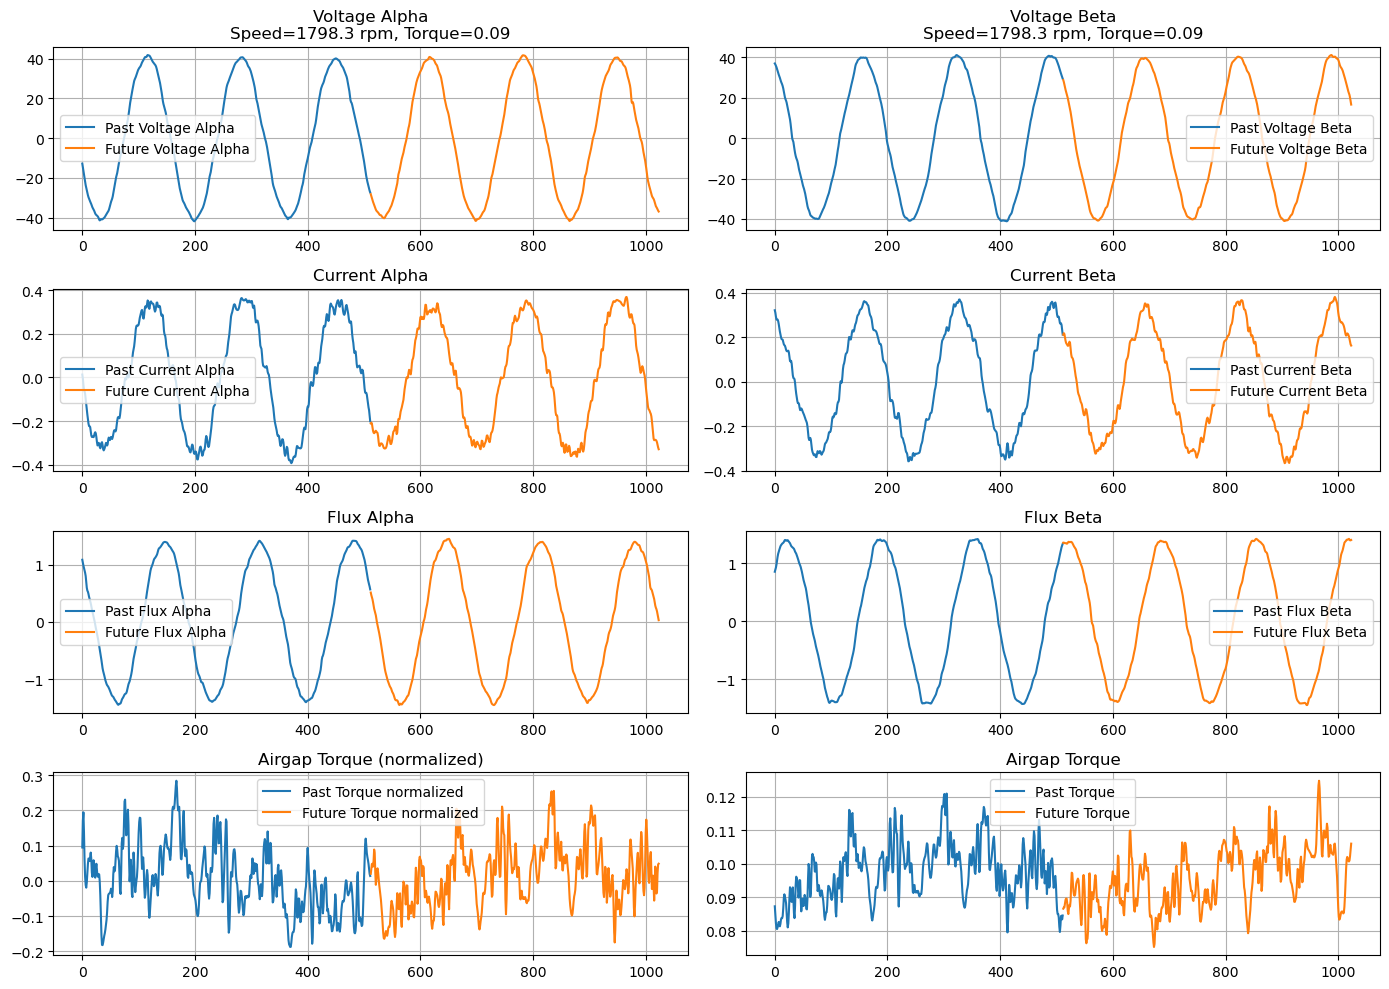

In [42]:
idx = 50  # 可調整索引以觀察不同樣本

def plot_raw_data(idx):
    fig, axs = plt.subplots(4, 2, figsize=(14, 10))
    time_past = np.arange(sequence_length)
    time_future = np.arange(sequence_length, sequence_length + future_length)

    # 取得運轉條件
    speed_val = speed_array_pu[idx, 0] * 3000  # 還原為 rpm
    torque_val = torque_array[idx, 0]

    # 電壓
    axs[0, 0].plot(time_past, past_voltages[idx, :, 0], label='Past Voltage Alpha')
    axs[0, 0].plot(time_future, future_voltages[idx, :, 0], label='Future Voltage Alpha')
    axs[0, 0].set_title(f'Voltage Alpha\nSpeed={speed_val:.1f} rpm, Torque={torque_val:.2f}')
    axs[0, 0].legend()
    axs[0, 0].grid(True)

    axs[0, 1].plot(time_past, past_voltages[idx, :, 1], label='Past Voltage Beta')
    axs[0, 1].plot(time_future, future_voltages[idx, :, 1], label='Future Voltage Beta')
    axs[0, 1].set_title(f'Voltage Beta\nSpeed={speed_val:.1f} rpm, Torque={torque_val:.2f}')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    # 電流
    axs[1, 0].plot(time_past, past_currents[idx, :, 0], label='Past Current Alpha')
    axs[1, 0].plot(time_future, future_currents[idx, :, 0], label='Future Current Alpha')
    axs[1, 0].set_title('Current Alpha')
    axs[1, 0].legend()
    axs[1, 0].grid(True)

    axs[1, 1].plot(time_past, past_currents[idx, :, 1], label='Past Current Beta')
    axs[1, 1].plot(time_future, future_currents[idx, :, 1], label='Future Current Beta')
    axs[1, 1].set_title('Current Beta')
    axs[1, 1].legend()
    axs[1, 1].grid(True)

    # 磁通
    axs[2, 0].plot(time_past, past_emf_normalized[idx, :, 0], label='Past Flux Alpha')
    axs[2, 0].plot(time_future, future_emf_normalized[idx, :, 0], label='Future Flux Alpha')
    axs[2, 0].set_title('Flux Alpha')
    axs[2, 0].legend()
    axs[2, 0].grid(True)

    axs[2, 1].plot(time_past, past_emf_normalized[idx, :, 1], label='Past Flux Beta')
    axs[2, 1].plot(time_future, future_emf_normalized[idx, :, 1], label='Future Flux Beta')
    axs[2, 1].set_title('Flux Beta')
    axs[2, 1].legend()
    axs[2, 1].grid(True)

    # 力矩
    print(past_airgap_torque_normalized.shape)
    axs[3, 0].plot(time_past, past_airgap_torque_normalized[idx, :,0], label='Past Torque normalized')
    axs[3, 0].plot(time_future, future_airgap_torque_normalized[idx, :,0], label='Future Torque normalized')
    axs[3, 0].set_title('Airgap Torque (normalized)')
    axs[3, 0].legend()
    axs[3, 0].grid(True)

    axs[3, 1].plot(time_past, past_airgap_torque[idx, : ,0], label='Past Torque')
    axs[3, 1].plot(time_future, future_airgap_torque[idx, :,0], label='Future Torque')
    axs[3, 1].set_title('Airgap Torque')
    axs[3, 1].legend()
    axs[3, 1].grid(True)

    plt.tight_layout()
    plt.show()
plot_raw_data(idx)

### 訊練 LSTM 模型 ###

### 1. EMF in EMF out ###

GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1/1 [==============================] - 1s 583ms/step
Model structures passed, start training...
Epoch 1/50
985/985 [==============================] - 111s 110ms/step - loss: 1.5579e-05 - val_loss: 9.0921e-06 - lr: 0.0010
Epoch 2/50
985/985 [==============================] - 107s 108ms/step - loss: 7.7846e-06 - val_loss: 4.2319e-06 - lr: 0.0010
Epoch 3/50
985/985 [==============================] - 106s 107ms/step - loss: 8.2660e-06 - val_loss: 6.1371e-06 - lr: 0.0010
Epoch 4/50
985/985 [==============================] - 109s 111ms/step - loss: 1.0746e-05 - val_loss: 3.5294e-06 - lr: 0.0010
Epoch 5/50
985/985 [==============================] - 112s 114ms/step - loss: 5.6585e-06 - val_loss: 3.6943e-06 - lr: 0.0010
Epoch 6/50
985/985 [==============================] - ETA: 0s - loss: 6.4842e-06
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
985/985 [=============================

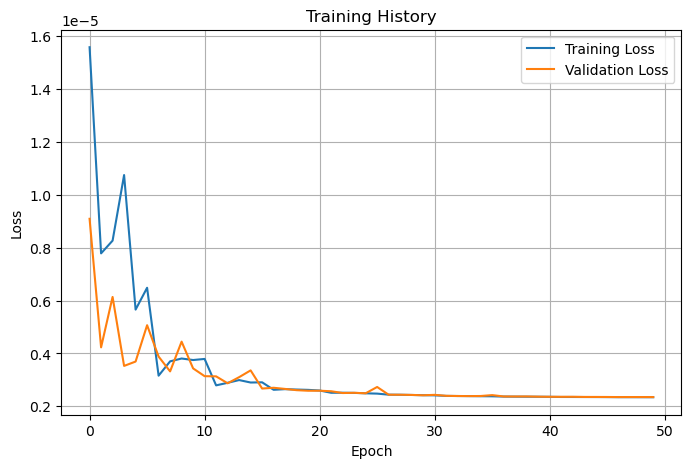

In [43]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPU devices found:")
for gpu in gpus:
    print(gpu)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
def combined_time_freq_loss(y_true, y_pred):
    # 時域 MSE
    mse_time = tf.reduce_mean(tf.square(y_true - y_pred))
    # 頻域 MSE（幅值）
    fft_true = tf.signal.rfft(y_true)
    fft_pred = tf.signal.rfft(y_pred)
    mse_freq = tf.reduce_mean(tf.square(tf.abs(fft_true - fft_pred)))
    # 自訂權重，或動態調整
    return 0.7 * mse_time + 0.3 * mse_freq

def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse'
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        # min_delta=1e-6,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

lr_scheduler_flux, early_stop_flux = compile_and_prepare_model(my_model_emf_in_emf_out)

my_model_emf_in_emf_out.predict([past_emf[0:1,:,:], speed_array_pu[0:1,:], torque_array[0:1,:]])
print("Model structures passed, start training...")

# # 開始訓練
# history_flux = my_model_emf_in_emf_out.fit(
#     x=[past_emf_normalized, speed_array_pu, torque_array], 
#     y=future_emf_normalized,
#     batch_size=128,
#     epochs=100,
#     validation_split=0.1, 
#     callbacks=[lr_scheduler_flux, early_stop_flux] 
# )

history_flux = my_model_emf_in_emf_out.fit(
    x=[past_emf, speed_array_pu, torque_array], 
    y=future_emf,
    batch_size=128,
    epochs=50,
    validation_split=0.1, 
    callbacks=[lr_scheduler_flux, early_stop_flux] 
)

plt.figure(figsize=(8, 5))
plt.plot(history_flux.history['loss'], label='Training Loss')
if 'val_loss' in history_flux.history:
    plt.plot(history_flux.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

metadata = {
    "model_name": model_name+'_EMF',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "trained": True,
    "train_loss": history_flux.history['loss'][-1],
    "val_loss": history_flux.history.get('val_loss', [None])[-1],
    "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open(os.path.join(model_path, model_name + '_Flux_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)

my_model_emf_in_emf_out.save(os.path.join(model_path, model_name + '_EMF.keras'))




1/1 [==============================] - 1s 609ms/step


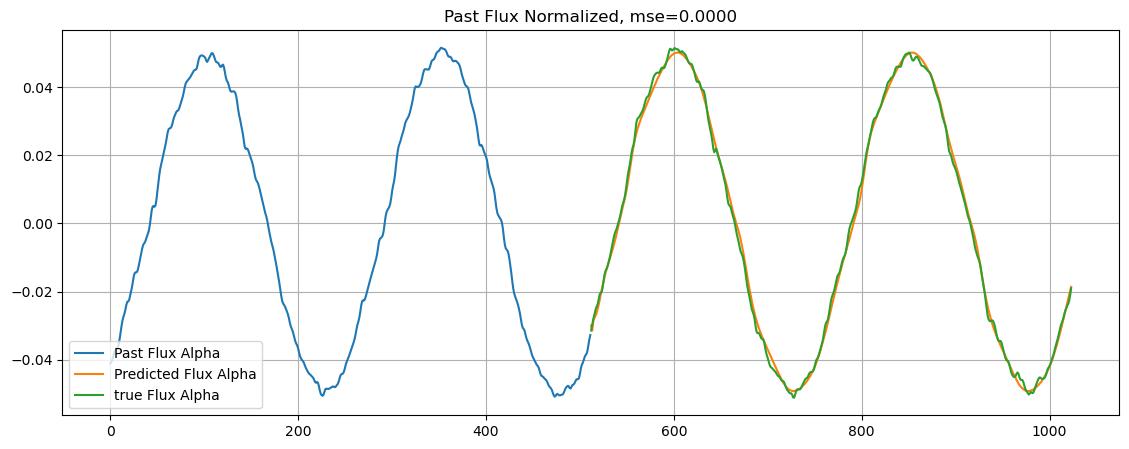

In [44]:
my_model_emf_in_emf_out= load_model(os.path.join(model_path, model_name + '_EMF.keras'))
# 檢視訓練結果
idx = 1  # 可調整索引以觀察不同樣本
# 用 idx 指定觀看 batch
predict_torque=my_model_emf_in_emf_out.predict([past_emf[idx:idx+1, :, :], speed_array_pu[idx:idx+1, :], torque_array[idx:idx+1, :]])
plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(range(sequence_length),past_emf[idx, :, 0], label='Past Flux Alpha')
plt.plot(range(sequence_length, sequence_length+future_length),predict_torque[0,:, 0], label='Predicted Flux Alpha')
plt.plot(range(sequence_length, sequence_length+future_length),future_emf[idx, :, 0], label='true Flux Alpha')
error= future_emf[idx, :, 0]-predict_torque[0,:, 0]
# plt.plot(range(sequence_length, sequence_length+future_length),error, label='Flux Alpha Error')
plt.title(f'Past Flux Normalized, mse={np.mean(np.square(error)):.4f}')
plt.legend()
plt.grid(True)


In [45]:
def list_subfolders(path):
    """列出指定路徑下的所有子資料夾"""
    return [f.path for f in os.scandir(path) if f.is_dir()]

def get_apply_files_data(Normal_subfolders, test_size=0.5):
    # 重採樣次數
    augmen_sample_number=100
    """取得指定工況資料夾下的所有檔案，並分取出部分作驗證"""
    parquet_files = [os.path.join(Normal_subfolders, f) for f in os.listdir(Normal_subfolders) if f.endswith(".parquet")]
    apply_parquet_files, _ = train_test_split(parquet_files, test_size=test_size)
        
    train_signals=[] # vi signals alpha beta 
    train_signals_normalized=[]
    torque_array=[]
    speed_array_pu=[]
   
    
    for file_path in apply_parquet_files:
        if not os.path.exists(file_path):
            print(f"File {file_path} does not exist.")
            continue
        # 讀取資料
        df = read_rul_data(file_path)
        if df["Voltage alpha thd"] > 0.1 or df["Voltage beta thd"] > 0.1 or df is None:
            print(f"File {file_path} has high THD, skipping.")
            continue
        current_alpha= np.array(df["Current alpha downsample"])
        current_beta= np.array(df["Current beta downsample"])
        flux_alpha= np.array(df["Flux alpha"])
        flux_beta= np.array(df["Flux beta"])
        if (flux_alpha.shape[0] != current_alpha.shape[0]):
            print(f"File {file_path} has mismatched flux and current lengths, skipping.")
            print(f"flux_alpha length: {flux_alpha.shape[0]}, current_alpha length: {current_alpha.shape[0]}")
            continue
        torque_airgap=1.5*4*(flux_alpha*current_beta-flux_beta*current_alpha)  # 計算 torque
        emf_alpha= (df["Voltage alpha downsample"] - Rs * current_alpha) / (df["Speed"][0] * P * 2 * np.pi / 60)  # 計算電動勢
        emf_beta= (df["Voltage beta downsample"] - Rs * current_beta) / (df["Speed"][0] * P * 2 * np.pi / 60)
        # 標準化
        torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.std(torque_airgap)
          
        torque= (df["Torque avg"]) 
        # print(df)
        speed= (df["Speed"][0])
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        temp_train_signals = [np.array(df["Voltage alpha downsample"]), 
                              np.array(df["Voltage beta downsample"]),
                              current_alpha,
                              current_beta,
                              flux_alpha,
                              flux_beta,
                              emf_alpha,
                              emf_beta,
                              torque_airgap]
        
        # 將數據正規化到 [-1, 1] 範圍
        temp_train_signals_normalized = []
        # for signal in temp_train_signals:
        #     min_val = np.min(signal)
        #     max_val = np.max(signal)
        #     # 避免除以零的狀況（max == min）
        #     if max_val == min_val:
        #         normalized = np.zeros_like(signal)
        #     else:
        #         normalized = 2 * (signal - min_val) / (max_val - min_val) - 1
        #     temp_train_signals_normalized.append(normalized)
            
        # 將數據標準化（均值為 0，標準差為 1）
        for signal in temp_train_signals:
            mean = np.mean(signal)
            std = np.std(signal)
            # 避免除以零的狀況（std == 0）
            if std == 0:
                standardized = np.zeros_like(signal)
            else:
                standardized = (signal - mean) / std
            temp_train_signals_normalized.append(standardized)
        
        
        temp_train_signals_normalized[-1]= torque_airgap_normalized  # 改成std正規化的 torque_airgap
        
        try:
            temp_train_signals = np.stack(temp_train_signals, axis=1)
            temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
        except ValueError as e:
            print(f"Error stacking signals for file {file_path}: {e}")
            print(f"datalength {len(df['Voltage alpha downsample'])}")
            continue
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        
        train_signals.append(temp_train_input_signals_augmented)
        train_signals_normalized.append(temp_train_signals_normalized_augmented)
        torque_array.append(np.ones(augmen_sample_number) * torque)
        speed_array_pu.append(np.ones(augmen_sample_number) * speed/3000) # rate 3000 rpm 
        
    train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
    train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
    torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
    speed_array_pu = np.concatenate(speed_array_pu, axis=0).astype(np.float32)
    
        
    # 將資料儲存到字典中
    apply_data = {
        "input_signals": train_signals[:, :sequence_length, :],                         # 取前 sequence_length 個時間步長
        "input_signals_normalized": train_signals_normalized[:, :sequence_length, :],   # 取前 sequence_length 個時間步長
        "fit_signals": train_signals[:, -future_length:, :],                            # 取最後 future_length 個時間步長
        "fit_signals_normalized": train_signals_normalized[:, -future_length:, :],      # 取最後 future_length 個時間步長
        "torque_array": torque_array.reshape(-1, 1),
        "speed_array_pu": speed_array_pu.reshape(-1, 1)  # rate 3000 rpm
    }
    return apply_data


# 不同故障重建誤差比對
Consitions=["1200 0.5v", "1200 1.0v", "1200 2.0v",
            "1800 0.5v", "1800 1.0v", "1800 2.0v",
            "3000 0.5v", "3000 1.0v", "3000 2.0v"]

#健康資料集
Normal_data_path= os.path.join(NTU_dataset_path, 'normal-2')
Normal_subfolders = list_subfolders(Normal_data_path)
#建立一個字典來儲存每個資料夾的檔案資料與數據
normal_datasets = {}
for folder in Normal_subfolders:
    normal_datasets[folder] = get_apply_files_data(folder)
    
#異常資料集
Abnormal_data_path = os.path.join(NTU_dataset_path, 'wear-out-2(worse)')
# Abnormal_data_path = os.path.join(NTU_dataset_path, 'drill 2mm 2mm q')
# Abnormal_data_path = os.path.join(NTU_dataset_path, 'cut 2mm')

Abnormal_subfolders = list_subfolders(Abnormal_data_path)    
abnormal_datasets = {}
for folder in Abnormal_subfolders:
    abnormal_datasets[folder] = get_apply_files_data(folder)


9/9 [==============================] - 0s 52ms/step
Condition: 1200 0.5v, Normal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 0.5v  2kg cm2, Abnormal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\wear-out-2(worse)\wear-out-2(worse) 1200 0.5v  2kg cm2
Condition: 1200 1.0v, Normal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 1.0v  2kg cm2, Abnormal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\wear-out-2(worse)\wear-out-2(worse) 1200 1.0v  2kg cm2
Condition: 1200 2.0v, Normal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1200 2.0v  2kg cm2, Abnormal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\wear-out-2(worse)\wear-out-2(worse) 1200 2.0v  2kg cm2
Condition: 1800 0.5v, Normal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\normal-2\normal-2 1800 0.5v  2kg cm2, Abnormal Key: D:\OneDrive\CCAE_experiments\CCAE_datasets2\wear-out-2(worse)\wear-out-2(worse) 1800 0.5v  2kg cm2
Condition: 1800 1.0v, Normal Key

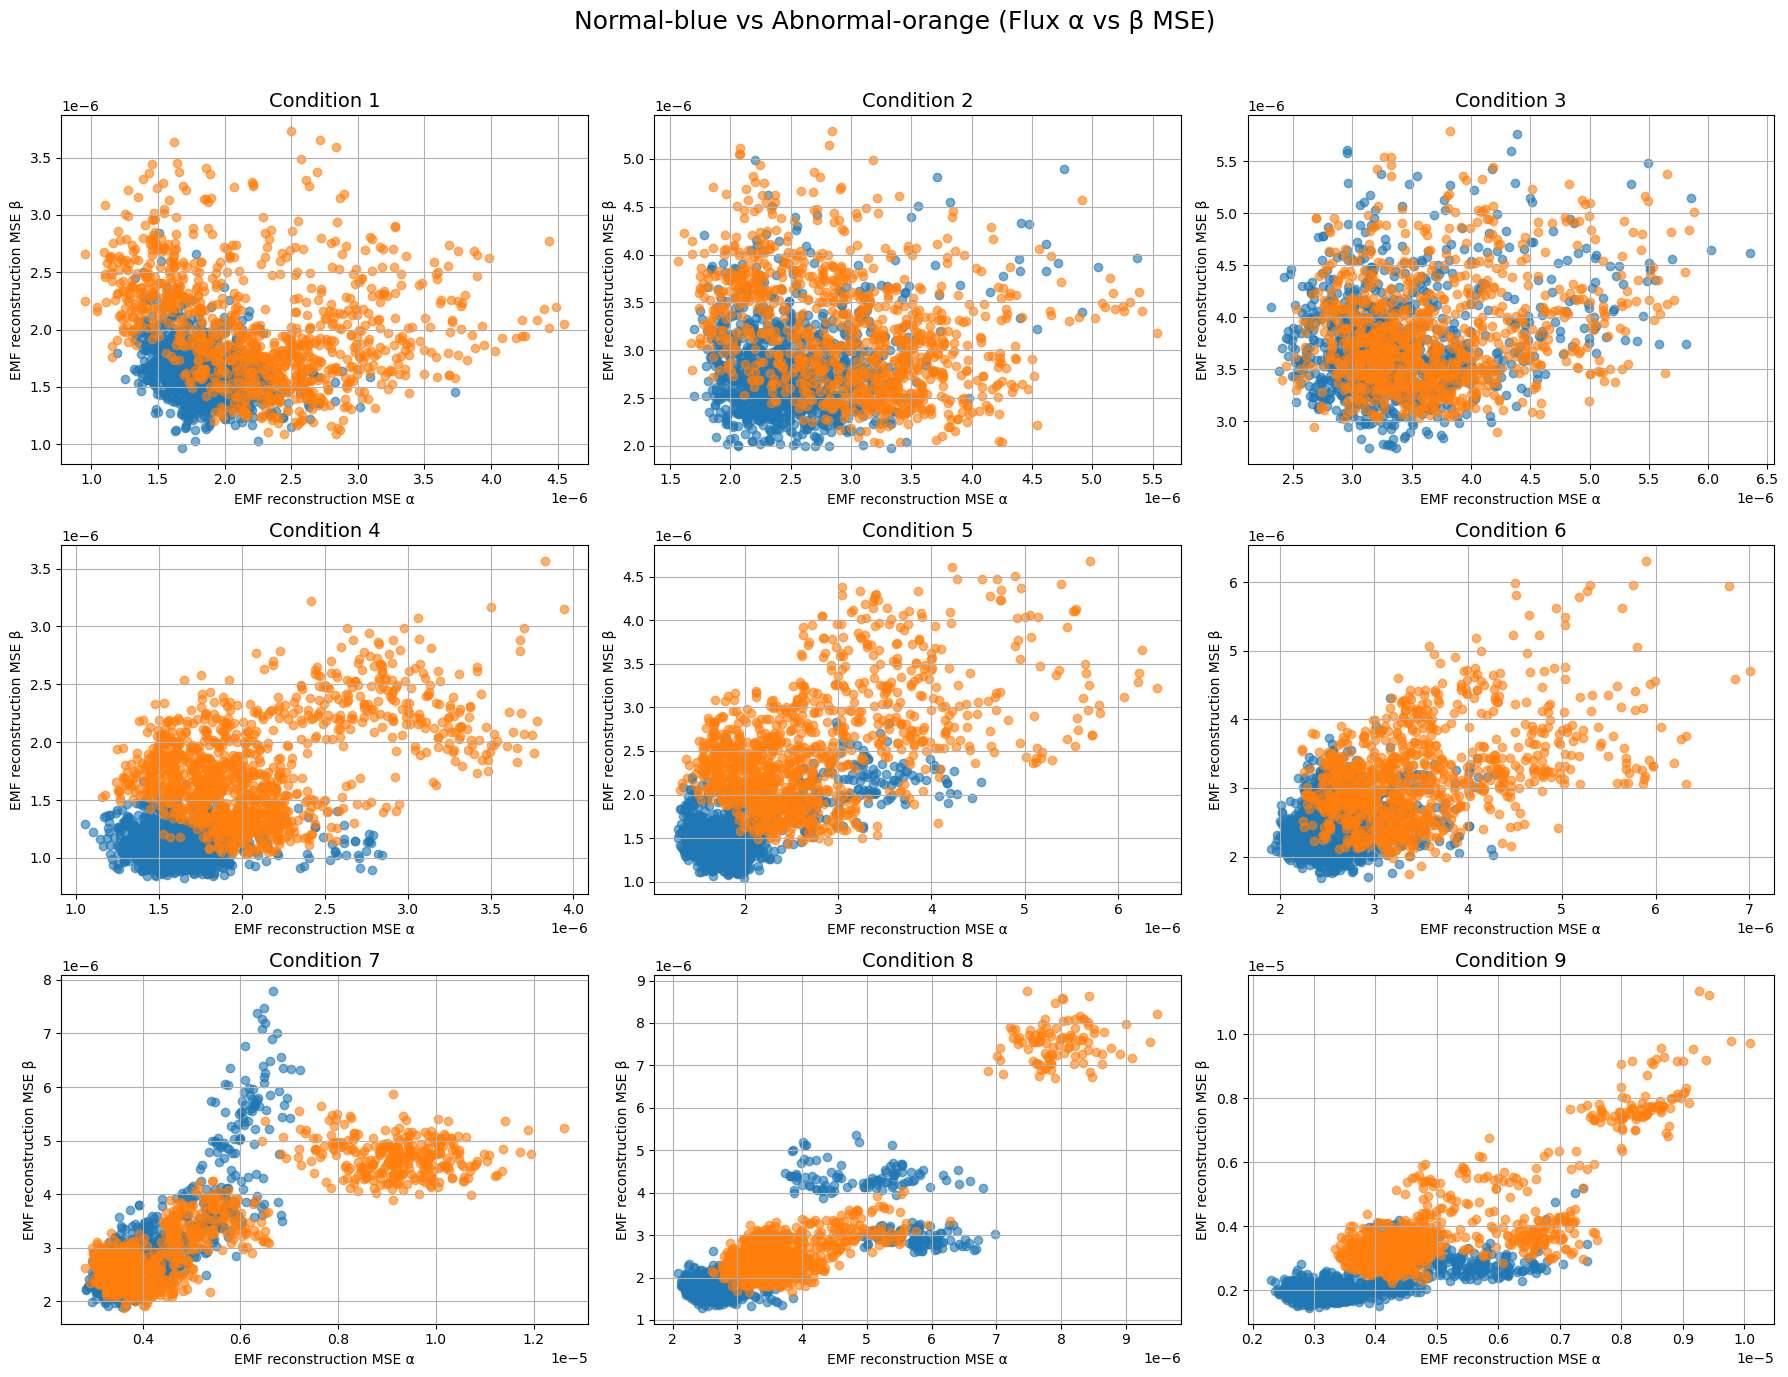

In [46]:

#計算重建MSE資料
normal_reconstruction_errors_emf = {}
for folder in Normal_subfolders:
    past_emf_normalized= normal_datasets[folder]["input_signals"][:, :, 6:8]  # 使用過去的 emf 作為輸入
    future_emf_normalized= normal_datasets[folder]["fit_signals"][:, :, 6:8]
    reconstruction_errors_flux=my_model_emf_in_emf_out.predict(
        [past_emf_normalized, 
        normal_datasets[folder]["speed_array_pu"], 
        normal_datasets[folder]["torque_array"]],
        batch_size=128)
    reconstruction_MSEs_flux_alpha = np.mean((reconstruction_errors_flux[:,:,0] - future_emf_normalized[:,:,0])**2,axis=(1))
    reconstruction_MSEs_flux_beta = np.mean((reconstruction_errors_flux[:,:,1] - future_emf_normalized[:,:,1])**2,axis=(1))
    normal_reconstruction_errors_emf[folder] = {"EMF_alpha_MSE": reconstruction_MSEs_flux_alpha,
                                                 "EMF_beta_MSE": reconstruction_MSEs_flux_beta}
    
abnormal_reconstruction_errors_emf = {}
for folder in Abnormal_subfolders:
    past_emf_normalized= abnormal_datasets[folder]["input_signals"][:, :, 6:8] 
    future_emf_normalized= abnormal_datasets[folder]["fit_signals"][:, :, 6:8]
    reconstruction_errors_flux=my_model_emf_in_emf_out.predict(
        [past_emf_normalized, 
        abnormal_datasets[folder]["speed_array_pu"], 
        abnormal_datasets[folder]["torque_array"]],
        batch_size=128)
    reconstruction_MSEs_flux_alpha = np.mean((reconstruction_errors_flux[:,:,0] - future_emf_normalized[:,:,0])**2,axis=(1))
    reconstruction_MSEs_flux_beta = np.mean((reconstruction_errors_flux[:,:,1] - future_emf_normalized[:,:,1])**2,axis=(1))
    abnormal_reconstruction_errors_emf[folder] = {"EMF_alpha_MSE": reconstruction_MSEs_flux_alpha,
                                                 "EMF_beta_MSE": reconstruction_MSEs_flux_beta}



# 畫出兩者間的分布圖
# Step 0: 定義 Condition Map
Condition_map = {
    '1200 0.5v': 'Condition 1',
    '1200 1.0v': 'Condition 2',
    '1200 2.0v': 'Condition 3',
    '1800 0.5v': 'Condition 4',
    '1800 1.0v': 'Condition 5',
    '1800 2.0v': 'Condition 6',
    '3000 0.5v': 'Condition 7',
    '3000 1.0v': 'Condition 8',
    '3000 2.0v': 'Condition 9',
}

# print(abnormal_reconstruction_errors_emf.items())


# Step 2: 遍歷 Condition_map，找到每個 Condition 在兩個 dict 中的 key
matched_conditions = []
for cond_key in Condition_map:
    
    normal_key = next((k for k in normal_reconstruction_errors_emf if cond_key in k), None)
    abnormal_key = next((k for k in abnormal_reconstruction_errors_emf if cond_key in k), None)
    print(f"Condition: {cond_key}, Normal Key: {normal_key}, Abnormal Key: {abnormal_key}")
    if normal_key and abnormal_key:
        matched_conditions.append((cond_key, normal_key, abnormal_key))

# Step 3: 畫圖
num_folders = len(matched_conditions)
num_figs = int(np.ceil(num_folders / 9))
print(num_figs)
for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    fig.suptitle("Normal-blue vs Abnormal-orange (Flux α vs β MSE)", fontsize=18)

    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_folders:
            axes.flat[i].set_visible(False)
            continue

        cond_key, normal_key, abnormal_key = matched_conditions[cond_idx]
        ax = axes.flat[i]

        # Normal Data
        x_normal = normal_reconstruction_errors_emf[normal_key]["EMF_alpha_MSE"].flatten()
        y_normal = normal_reconstruction_errors_emf[normal_key]["EMF_beta_MSE"].flatten()
        # Abnormal Data
        x_abnormal = abnormal_reconstruction_errors_emf[abnormal_key]["EMF_alpha_MSE"].flatten()
        y_abnormal = abnormal_reconstruction_errors_emf[abnormal_key]["EMF_beta_MSE"].flatten()
        # 畫直方圖
        ax.scatter(x_normal, y_normal, label="Normal", color='tab:blue', alpha=0.6)
        ax.scatter(x_abnormal, y_abnormal, label="Abnormal", color='tab:orange', alpha=0.6)
    
        # ax.legend()
        ax.set_xlabel("EMF reconstruction MSE α")
        ax.set_ylabel("EMF reconstruction MSE β")
        ax.set_title(Condition_map[cond_key], fontsize=14)
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


### 1. 力矩 in 力矩 out ###

GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1/1 [==============================] - 1s 601ms/step
Model structures passed, start training...
Epoch 1/50
380/380 [==============================] - 50s 124ms/step - loss: 0.0049 - val_loss: 0.0039 - lr: 0.0010
Epoch 2/50
380/380 [==============================] - 46s 121ms/step - loss: 0.0035 - val_loss: 0.0032 - lr: 0.0010
Epoch 3/50
380/380 [==============================] - 46s 121ms/step - loss: 0.0029 - val_loss: 0.0026 - lr: 0.0010
Epoch 4/50
380/380 [==============================] - 46s 121ms/step - loss: 0.0025 - val_loss: 0.0023 - lr: 0.0010
Epoch 5/50
380/380 [==============================] - 46s 121ms/step - loss: 0.0023 - val_loss: 0.0024 - lr: 0.0010
Epoch 6/50
380/380 [==============================] - 46s 121ms/step - loss: 0.0021 - val_loss: 0.0019 - lr: 0.0010
Epoch 7/50
380/380 [==============================] - 46s 121ms/step - loss: 0.0021 - val_loss: 0.0020 - lr: 0.0010
Epoch 8/

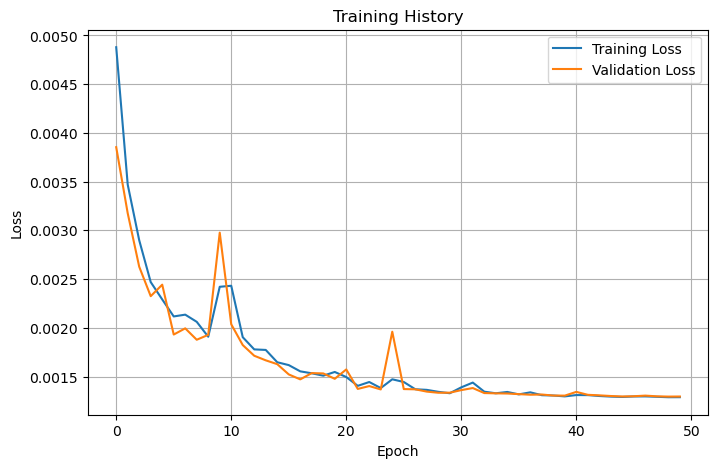

In [105]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPU devices found:")
for gpu in gpus:
    print(gpu)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
def combined_time_freq_loss(y_true, y_pred):
    # 時域 MSE
    mse_time = tf.reduce_mean(tf.square(y_true - y_pred))
    # 頻域 MSE（幅值）
    fft_true = tf.signal.rfft(y_true)
    fft_pred = tf.signal.rfft(y_pred)
    mse_freq = tf.reduce_mean(tf.square(tf.abs(fft_true - fft_pred)))
    # 自訂權重，或動態調整
    return 0.7 * mse_time + 0.3 * mse_freq

def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse'
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

lr_scheduler_flux, early_stop_flux = compile_and_prepare_model(my_model_Torq_in_Torq_out)

my_model_Torq_in_Torq_out.predict([past_airgap_torque_normalized[0:1,:,:], speed_array_pu[0:1,:], torque_array[0:1,:]])
print("Model structures passed, start training...")

# 開始訓練
#nromalized version
history_flux = my_model_Torq_in_Torq_out.fit(
    x=[past_airgap_torque_normalized, speed_array_pu, torque_array], 
    y=future_airgap_torque_normalized,
    batch_size=256,
    epochs=50,
    validation_split=0.1, 
    callbacks=[lr_scheduler_flux, early_stop_flux] 
)

# history_flux = my_model_Torq_in_Torq_out.fit(
#     x=[past_airgap_torque, speed_array_pu, torque_array], 
#     y=future_airgap_torque,
#     batch_size=128,
#     epochs=50,
#     validation_split=0.1, 
#     callbacks=[lr_scheduler_flux, early_stop_flux] 
# )

plt.figure(figsize=(8, 5))
plt.plot(history_flux.history['loss'], label='Training Loss')
if 'val_loss' in history_flux.history:
    plt.plot(history_flux.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

metadata = {
    "model_name": model_name+'_Torque',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "trained": True,
    "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open(os.path.join(model_path, model_name + '_Torque_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
    
# 儲存模型    
my_model_Torq_in_Torq_out.save(os.path.join(model_path, model_name + '_Torque.keras'))
test=load_model(os.path.join(model_path, model_name + '_Torque.keras'))


1/1 [==============================] - 1s 837ms/step


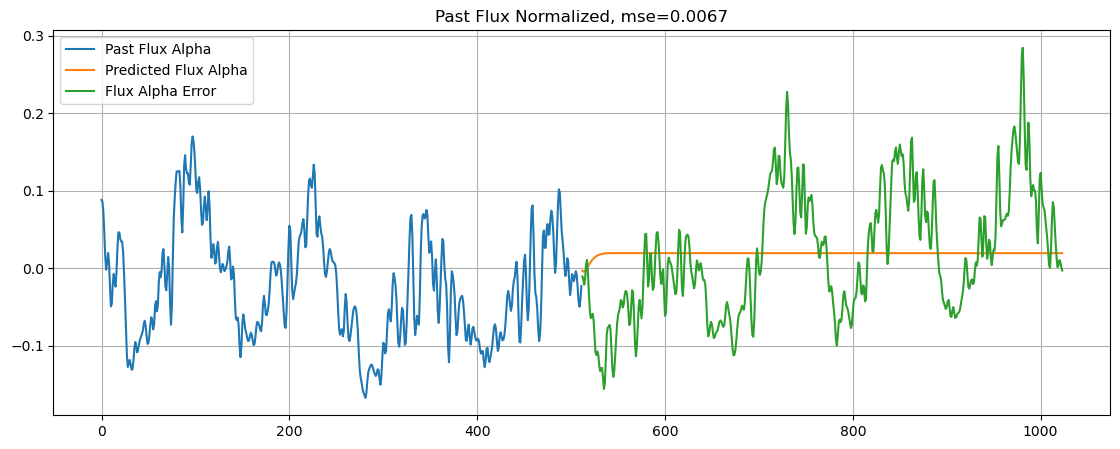

In [15]:
# 確認訓練成果
# 訓練資料驗證
idx = 2500  # 可調整索引以觀察不同樣本
# 用 idx 指定觀看 batch
predict_torque=my_model_Torq_in_Torq_out.predict([past_airgap_torque_normalized[idx:idx+1, :, :], speed_array_pu[idx:idx+1, :], torque_array[idx:idx+1, :]])
plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(range(sequence_length),past_airgap_torque_normalized[idx, :, 0], label='Past Flux Alpha')
plt.plot(range(sequence_length, sequence_length+future_length),predict_torque[0,:, 0], label='Predicted Flux Alpha')
# plt.plot(range(sequence_length, sequence_length+future_length),future_airgap_torque_normalized[idx, :, 0], label='true Flux Alpha')
error= future_airgap_torque_normalized[idx, :, 0]-predict_torque[0,:, 0]
plt.plot(range(sequence_length, sequence_length+future_length),error, label='Flux Alpha Error')
plt.title(f'Past Flux Normalized, mse={np.mean(np.square(error)):.4f}')
plt.legend()
plt.grid(True)

In [112]:
import numpy as np
import matplotlib.pyplot as plt
import os
def list_subfolders(path):
    """列出指定路徑下的所有子資料夾"""
    return [f.path for f in os.scandir(path) if f.is_dir()]
def get_apply_files_data(Normal_subfolders, test_size=0.5):
    
    augmen_sample_number=100 #驗證即可減少訓練數據需要
    
    """取得指定工況資料夾下的所有檔案，並分取出部分作驗證"""
    parquet_files = [os.path.join(Normal_subfolders, f) for f in os.listdir(Normal_subfolders) if f.endswith(".parquet")]
    apply_parquet_files, _ = train_test_split(parquet_files, test_size=test_size)
        
    train_signals=[] # vi signals alpha beta 
    train_signals_normalized=[]
    torque_array=[]
    speed_array_pu=[]
   
    
    for file_path in apply_parquet_files:
        if not os.path.exists(file_path):
            print(f"File {file_path} does not exist.")
            continue
        # 讀取資料
        df = read_rul_data(file_path)
        if df["Voltage alpha thd"] > 0.1 or df["Voltage beta thd"] > 0.1 or df is None:
            print(f"File {file_path} has high THD, skipping.")
            continue
        current_alpha= np.array(df["Current alpha downsample"])
        current_beta= np.array(df["Current beta downsample"])
        flux_alpha= np.array(df["Flux alpha"])
        flux_beta= np.array(df["Flux beta"])
        try:
            torque_airgap=1.5*4*(flux_alpha*current_beta-flux_beta*current_alpha)  # 計算 torque
        except Exception as e:
            print(f"Error calculating torque for file {file_path}: {e}")
            print(f"datalength {len(df['Voltage alpha downsample'])}")
            continue
        # 標準化
        torque_airgap_normalized = (torque_airgap - np.mean(torque_airgap)) / np.std(torque_airgap)
        if np.isnan(torque_airgap_normalized).any():
            print(f"NaN values found in torque_airgap_normalized for file {file_path}, skipping.")
            continue
        torque= (df["Torque avg"]) 
        # print(df)
        speed= (df["Speed"][0])
        
        # 合併測試資料至訓練維度 shape=(,4000,dim)
        temp_train_signals = [np.array(df["Voltage alpha downsample"]), 
                              np.array(df["Voltage beta downsample"]),
                              current_alpha,
                              current_beta,
                              flux_alpha,
                              flux_beta,
                              torque_airgap]  # 包含 torque_airgap
        
        # 將數據正規化到 [-1, 1] 範圍
        temp_train_signals_normalized = []
        for signal in temp_train_signals:
            min_val = np.min(signal)
            max_val = np.max(signal)
            # 避免除以零的狀況（max == min）
            if max_val == min_val:
                normalized = np.zeros_like(signal)
            else:
                normalized = 2 * (signal - min_val) / (max_val - min_val) - 1
            temp_train_signals_normalized.append(normalized)
        
        
        temp_train_signals_normalized[-1]= torque_airgap_normalized  # 改成std正規化的 torque_airgap
        
        try:
            temp_train_signals = np.stack(temp_train_signals, axis=1)
            temp_train_signals_normalized = np.stack(temp_train_signals_normalized, axis=1)
        except ValueError as e:
            print(f"Error stacking signals for file {file_path}: {e}")
            print(f"datalength {len(df['Voltage alpha downsample'])}")
            continue
        temp_train_input_signals_augmented = data_random_augmentation(temp_train_signals, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        temp_train_signals_normalized_augmented = data_random_augmentation(temp_train_signals_normalized, sequence_length, augmen_sample_number=augmen_sample_number,future_length=future_length)
        
        train_signals.append(temp_train_input_signals_augmented)
        train_signals_normalized.append(temp_train_signals_normalized_augmented)
        torque_array.append(np.ones(augmen_sample_number) * torque)
        speed_array_pu.append(np.ones(augmen_sample_number) * speed/3000) # rate 3000 rpm 
        
    train_signals = np.concatenate(train_signals, axis=0).astype(np.float32)
    train_signals_normalized = np.concatenate(train_signals_normalized, axis=0).astype(np.float32)
    torque_array = np.concatenate(torque_array, axis=0).astype(np.float32)
    speed_array_pu = np.concatenate(speed_array_pu, axis=0).astype(np.float32)
    
        
    # 將資料儲存到字典中
    apply_data = {
        "input_signals": train_signals[:, :sequence_length, :],                         # 取前 sequence_length 個時間步長
        "input_signals_normalized": train_signals_normalized[:, :sequence_length, :],   # 取前 sequence_length 個時間步長
        "fit_signals": train_signals[:, -future_length:, :],                            # 取最後 future_length 個時間步長
        "fit_signals_normalized": train_signals_normalized[:, -future_length:, :],      # 取最後 future_length 個時間步長
        "torque_array": torque_array.reshape(-1, 1),
        "speed_array_pu": speed_array_pu.reshape(-1, 1)  # rate 3000 rpm
    }
    return apply_data



# 不同故障重建誤差比對
Consitions=["1200 0.5v", "1200 1.0v", "1200 2.0v",
            "1800 0.5v", "1800 1.0v", "1800 2.0v",
            "3000 0.5v", "3000 1.0v", "3000 2.0v"]

#健康資料集
Normal_data_path= os.path.join(NTU_dataset_path, 'normal-2')
Normal_subfolders = list_subfolders(Normal_data_path)
#建立一個字典來儲存每個資料夾的檔案資料與數據
normal_datasets = {}
for folder in Normal_subfolders:
    normal_datasets[folder] = get_apply_files_data(folder)
    
#異常資料集
Abnormal_data_path = os.path.join(NTU_dataset_path, 'wear-out-2(worse)')
Abnormal_subfolders = list_subfolders(Abnormal_data_path)    
abnormal_datasets = {}
for folder in Abnormal_subfolders:
    abnormal_datasets[folder] = get_apply_files_data(folder)



8/8 [==============================] - 0s 40ms/step
(1000, 512, 1)
8/8 [==============================] - 0s 45ms/step
(1000, 512, 1)
8/8 [==============================] - 0s 41ms/step
(1000, 512, 1)
10/10 [==============================] - 0s 40ms/step
(1200, 512, 1)
9/9 [==============================] - 0s 41ms/step
(1100, 512, 1)
8/8 [==============================] - 0s 41ms/step
(1000, 512, 1)
10/10 [==============================] - 0s 38ms/step
(1200, 512, 1)
9/9 [==============================] - 0s 39ms/step
(1100, 512, 1)
9/9 [==============================] - 0s 41ms/step
(1100, 512, 1)


In [49]:
print(Normal_subfolders)

['D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 1200 0.5v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 1200 1.0v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 1200 2.0v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 1800 0.5v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 1800 1.0v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 1800 2.0v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 3000 0.5v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 3000 1.0v  2kg cm2', 'D:\\OneDrive\\CCAE_experiments\\CCAE_datasets2\\normal-2\\normal-2 3000 2.0v  2kg cm2']


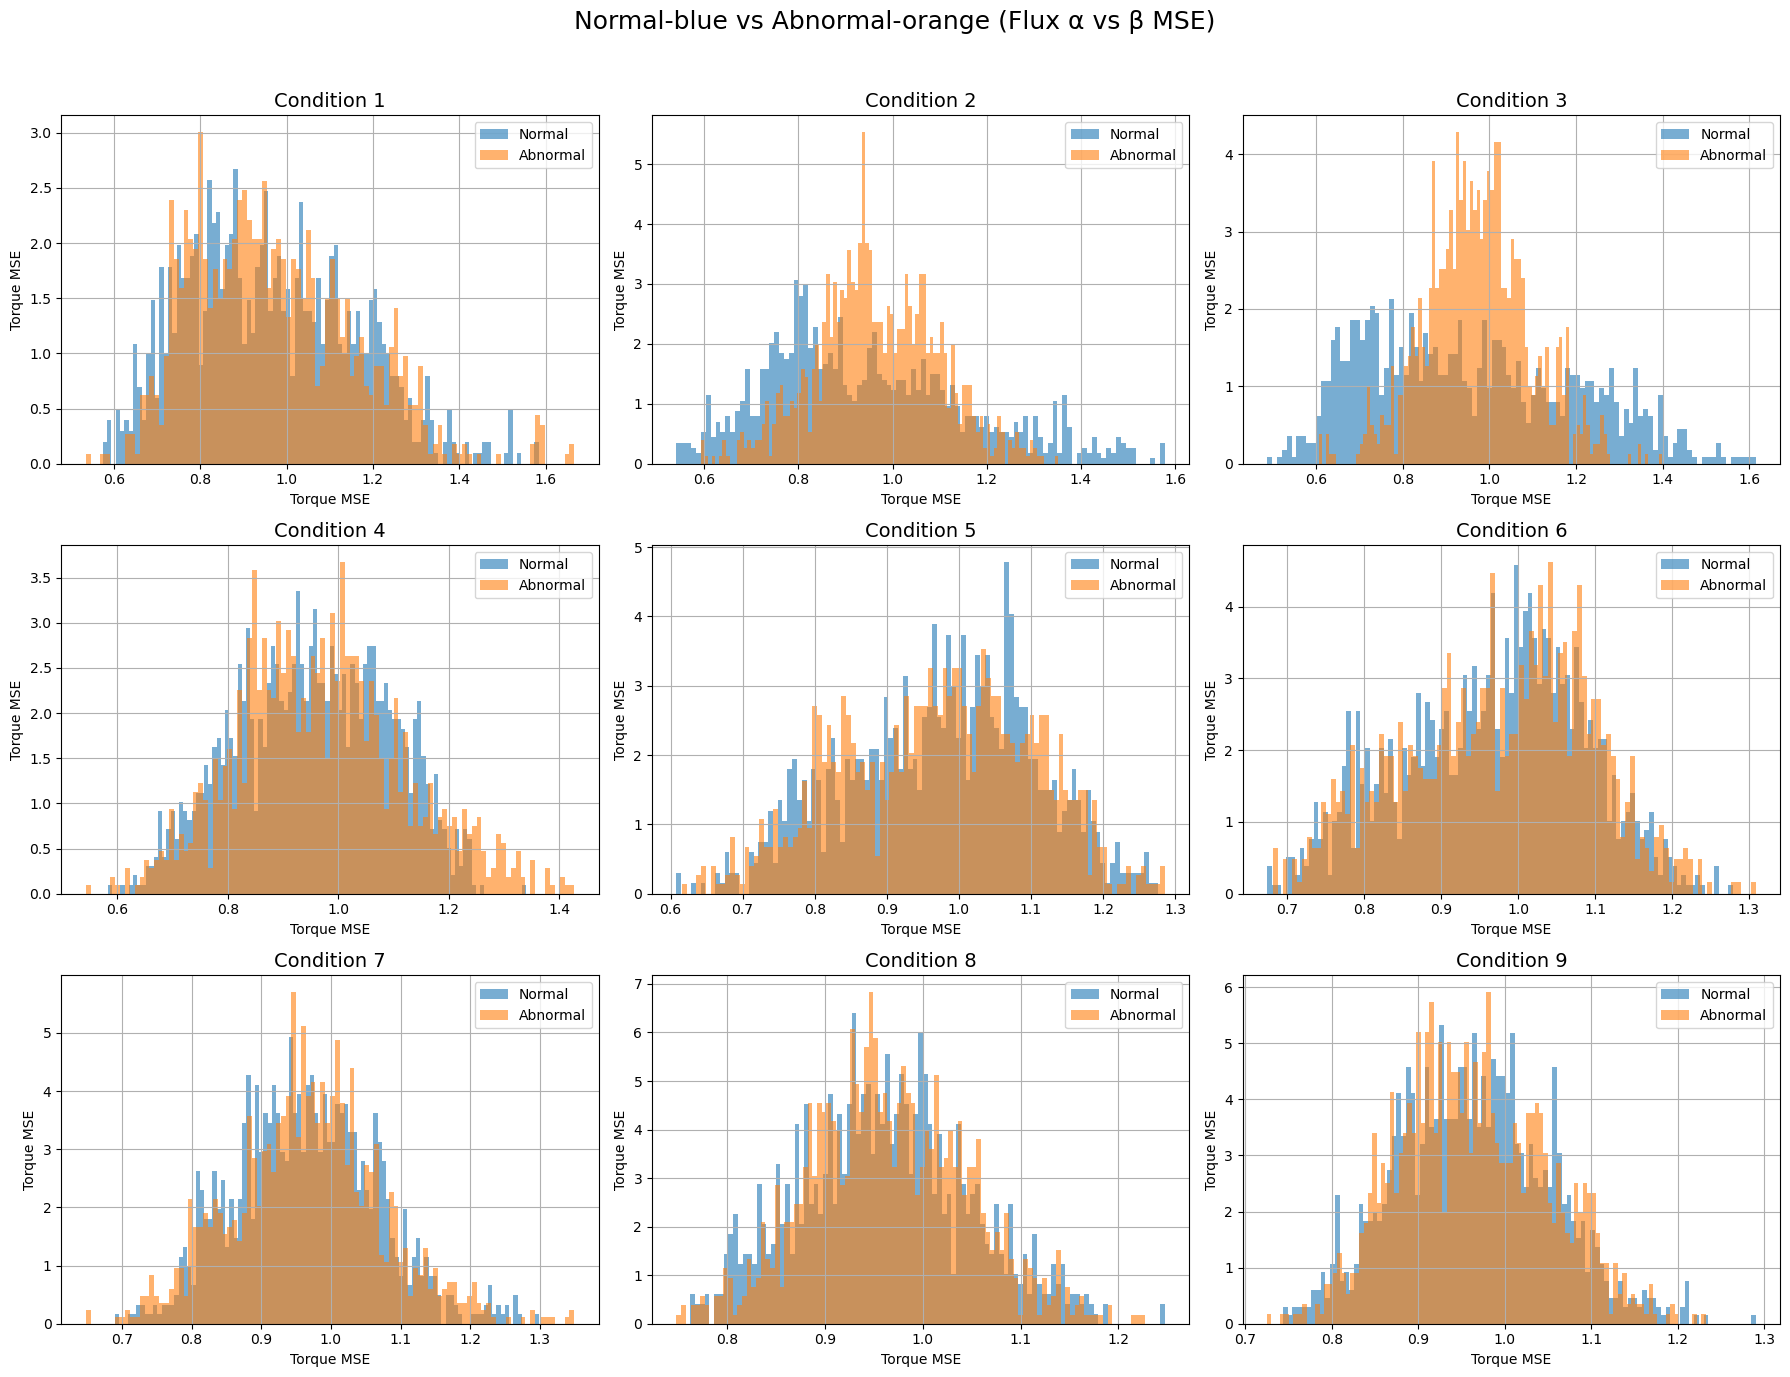

In [ ]:

# 畫出兩者間的分布圖
# Step 0: 定義 Condition Map
Condition_map = {
    '1200 0.5v': 'Condition 1',
    '1200 1.0v': 'Condition 2',
    '1200 2.0v': 'Condition 3',
    '1800 0.5v': 'Condition 4',
    '1800 1.0v': 'Condition 5',
    '1800 2.0v': 'Condition 6',
    '3000 0.5v': 'Condition 7',
    '3000 1.0v': 'Condition 8',
    '3000 2.0v': 'Condition 9',
}

#計算重建MSE資料
normal_reconstruction_errors_torque = {}
for folder in Normal_subfolders:
    reconstruction_errors_torque=my_model_Torq_in_Torq_out.predict(
        [normal_datasets[folder]["input_signals_normalized"][:, :, 6:7], 
        normal_datasets[folder]["speed_array_pu"], 
        normal_datasets[folder]["torque_array"]],
        batch_size=128)
    mse_per_sample = np.mean((reconstruction_errors_torque - normal_datasets[folder]["fit_signals_normalized"][:,:,6:7]) ** 2, axis=(1, 2))
    normal_reconstruction_errors_torque[folder] = {"Torque_MSE": mse_per_sample}
    
abnormal_reconstruction_errors_torque = {}
for folder in Abnormal_subfolders:
    reconstruction_errors_torque=my_model_Torq_in_Torq_out.predict(
        [abnormal_datasets[folder]["input_signals_normalized"][:, :, 6:7], 
        abnormal_datasets[folder]["speed_array_pu"], 
        abnormal_datasets[folder]["torque_array"]],
        batch_size=128)
    mse_per_sample = np.mean((reconstruction_errors_torque - abnormal_datasets[folder]["fit_signals_normalized"][:,:,6:7]) ** 2, axis=(1, 2))
    # reconstruction_MSEs_torque = np.mean(np.square(reconstruction_errors_torque - abnormal_datasets[folder]["fit_signals_normalized"][:,:,6:7]), axis=-1)
    print(reconstruction_errors_torque.shape)
    abnormal_reconstruction_errors_torque[folder] = {"Torque_MSE": mse_per_sample}

# Step 1: 將 normal 和 abnormal 分類好
golden_sample_dict = normal_reconstruction_errors_torque
compare_sample_dict = abnormal_reconstruction_errors_torque

# Step 2: 遍歷 Condition_map，找到每個 Condition 在兩個 dict 中的 key
matched_conditions = []
for cond_key in Condition_map:
    normal_key = next((k for k in golden_sample_dict if cond_key in k), None)
    abnormal_key = next((k for k in compare_sample_dict if cond_key in k), None)
    if normal_key and abnormal_key:
        matched_conditions.append((cond_key, normal_key, abnormal_key))

# Step 3: 畫圖
num_folders = len(matched_conditions)
num_figs = int(np.ceil(num_folders / 9))

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    fig.suptitle("Normal-blue vs Abnormal-orange (Flux α vs β MSE)", fontsize=18)

    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_folders:
            axes.flat[i].set_visible(False)
            continue

        cond_key, normal_key, abnormal_key = matched_conditions[cond_idx]
        ax = axes.flat[i]

        # Normal Data
        x_normal = golden_sample_dict[normal_key]["Torque_MSE"].flatten()
        # Abnormal Data
        x_abnormal = compare_sample_dict[abnormal_key]["Torque_MSE"].flatten()
        # 畫直方圖
        # ax.plot(range(len(x_normal)), x_normal, label="Normal", color='tab:blue', alpha=0.6)
        # ax.plot(range(len(x_abnormal)), x_abnormal, label="Abnormal", color='tab:orange', alpha=0.6)
        ax.hist(x_normal, bins=100, alpha=0.6, label="Normal", color='tab:blue', density=True)
        ax.hist(x_abnormal, bins=100, alpha=0.6, label="Abnormal", color='tab:orange', density=True)
        ax.legend()
        ax.set_xlabel("Torque MSE")
        ax.set_ylabel("Torque MSE")
        ax.set_title(Condition_map[cond_key], fontsize=14)
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


### 3. 電流 in 電流 out ###
訓練

GPU devices found:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1/1 [==============================] - 1s 544ms/step
Model structures passed, start training...
Epoch 1/50
380/380 [==============================] - 49s 123ms/step - loss: 0.7183 - val_loss: 0.7528 - lr: 0.0010
Epoch 2/50
380/380 [==============================] - 64s 170ms/step - loss: 0.3760 - val_loss: 0.8604 - lr: 0.0010
Epoch 3/50
380/380 [==============================] - 63s 164ms/step - loss: 0.8205 - val_loss: 0.7891 - lr: 0.0010
Epoch 4/50
380/380 [==============================] - 45s 118ms/step - loss: 0.4404 - val_loss: 0.1959 - lr: 0.0010
Epoch 5/50
380/380 [==============================] - 45s 120ms/step - loss: 0.6894 - val_loss: 0.6173 - lr: 0.0010
Epoch 6/50
380/380 [==============================] - 45s 119ms/step - loss: 0.6122 - val_loss: 0.4939 - lr: 0.0010
Epoch 7/50
380/380 [==============================] - 45s 119ms/step - loss: 0.3990 - val_loss: 0.3255 - lr: 0.0010
Epoch 8/

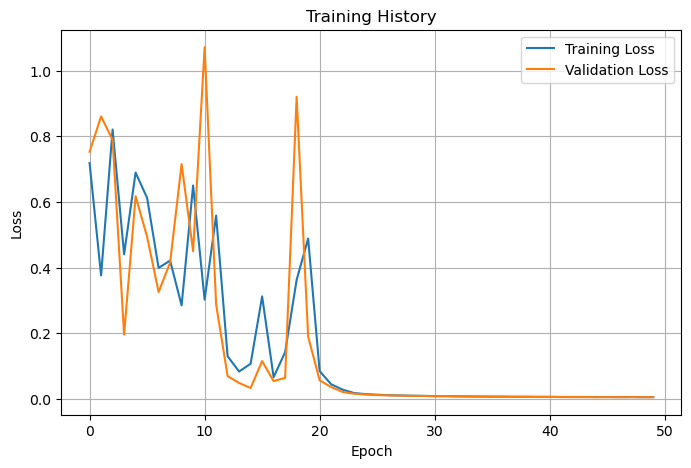

In [37]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

gpus = tf.config.experimental.list_physical_devices('GPU')
print("GPU devices found:")
for gpu in gpus:
    print(gpu)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
def combined_time_freq_loss(y_true, y_pred):
    # 時域 MSE
    mse_time = tf.reduce_mean(tf.square(y_true - y_pred))
    # 頻域 MSE（幅值）
    fft_true = tf.signal.rfft(y_true)
    fft_pred = tf.signal.rfft(y_pred)
    mse_freq = tf.reduce_mean(tf.square(tf.abs(fft_true - fft_pred)))
    # 自訂權重，或動態調整
    return 0.7 * mse_time + 0.3 * mse_freq

def compile_and_prepare_model(model, initial_learning_rate=1e-3):
    
    model.compile(
        optimizer=Adam(learning_rate=initial_learning_rate),
        loss='mse'
    )

    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=0.00001,
        restore_best_weights=True,
        verbose=1
    )
    return lr_scheduler, early_stop

lr_scheduler_I, early_stop_I = compile_and_prepare_model(my_model_I_in_I_out)

my_model_I_in_I_out.predict([past_currents_normalized[0:1,:,:]])
print("Model structures passed, start training...")

# 開始訓練
#nromalized version
history_I = my_model_I_in_I_out.fit(
    x=[past_currents_normalized], 
    y=future_currents_normalized,
    batch_size=256,
    epochs=50,
    validation_split=0.1, 
    callbacks=[lr_scheduler_I, early_stop_I] 
)

plt.figure(figsize=(8, 5))
plt.plot(history_I.history['loss'], label='Training Loss')
if 'val_loss' in history_I.history:
    plt.plot(history_I.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch') 
plt.ylabel('Loss')
plt.title('Training History')
plt.legend()
plt.grid(True)
plt.show()

metadata = {
    "model_name": model_name+'_I',
    "sequence_length": sequence_length,
    "layer_number": layer_number,
    "trained": True,
    "train_date": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
}

with open(os.path.join(model_path, model_name + '_I_metadata.json'), "w", encoding="utf-8") as f:
    json.dump(metadata, f, ensure_ascii=False, indent=4)
    

# 儲存模型    
my_model_I_in_I_out.save(os.path.join(model_path, model_name + '_I.keras'))
test=load_model(os.path.join(model_path, model_name + '_I.keras'))


結果展示

1/1 [==============================] - 1s 574ms/step


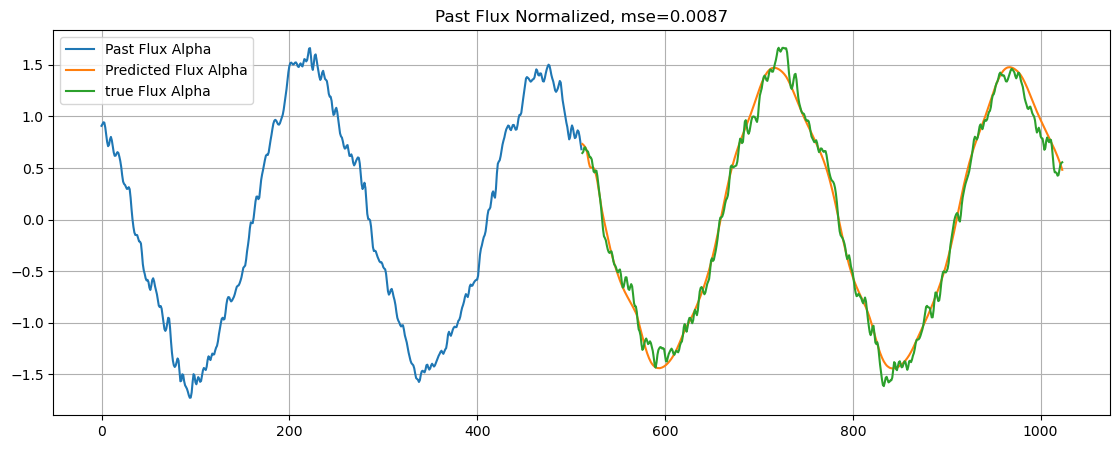

In [20]:
# 確認訓練成果
# 訓練資料驗證
my_model_I_in_I_out= load_model(os.path.join(model_path, model_name + '_I.keras'))
idx = 3  # 可調整索引以觀察不同樣本
# 用 idx 指定觀看 batch
predict_torque=my_model_I_in_I_out.predict([past_currents_normalized[idx:idx+1, :, :]])
plt.figure(figsize=(30, 5))
plt.subplot(1, 2, 1)
plt.plot(range(sequence_length),past_currents_normalized[idx, :, 1], label='Past Flux Alpha')
plt.plot(range(sequence_length, sequence_length+future_length),predict_torque[0,:, 1], label='Predicted Flux Alpha')
plt.plot(range(sequence_length, sequence_length+future_length),future_currents_normalized[idx, :, 1], label='true Flux Alpha')
error= future_currents_normalized[idx, :, 1]-predict_torque[0,:, 1]
# plt.plot(range(sequence_length, sequence_length+future_length),error, label='Flux Alpha Error')
plt.title(f'Past Flux Normalized, mse={np.mean(np.square(error)):.4f}')
plt.legend()
plt.grid(True)



9/9 [==============================] - 0s 41ms/step


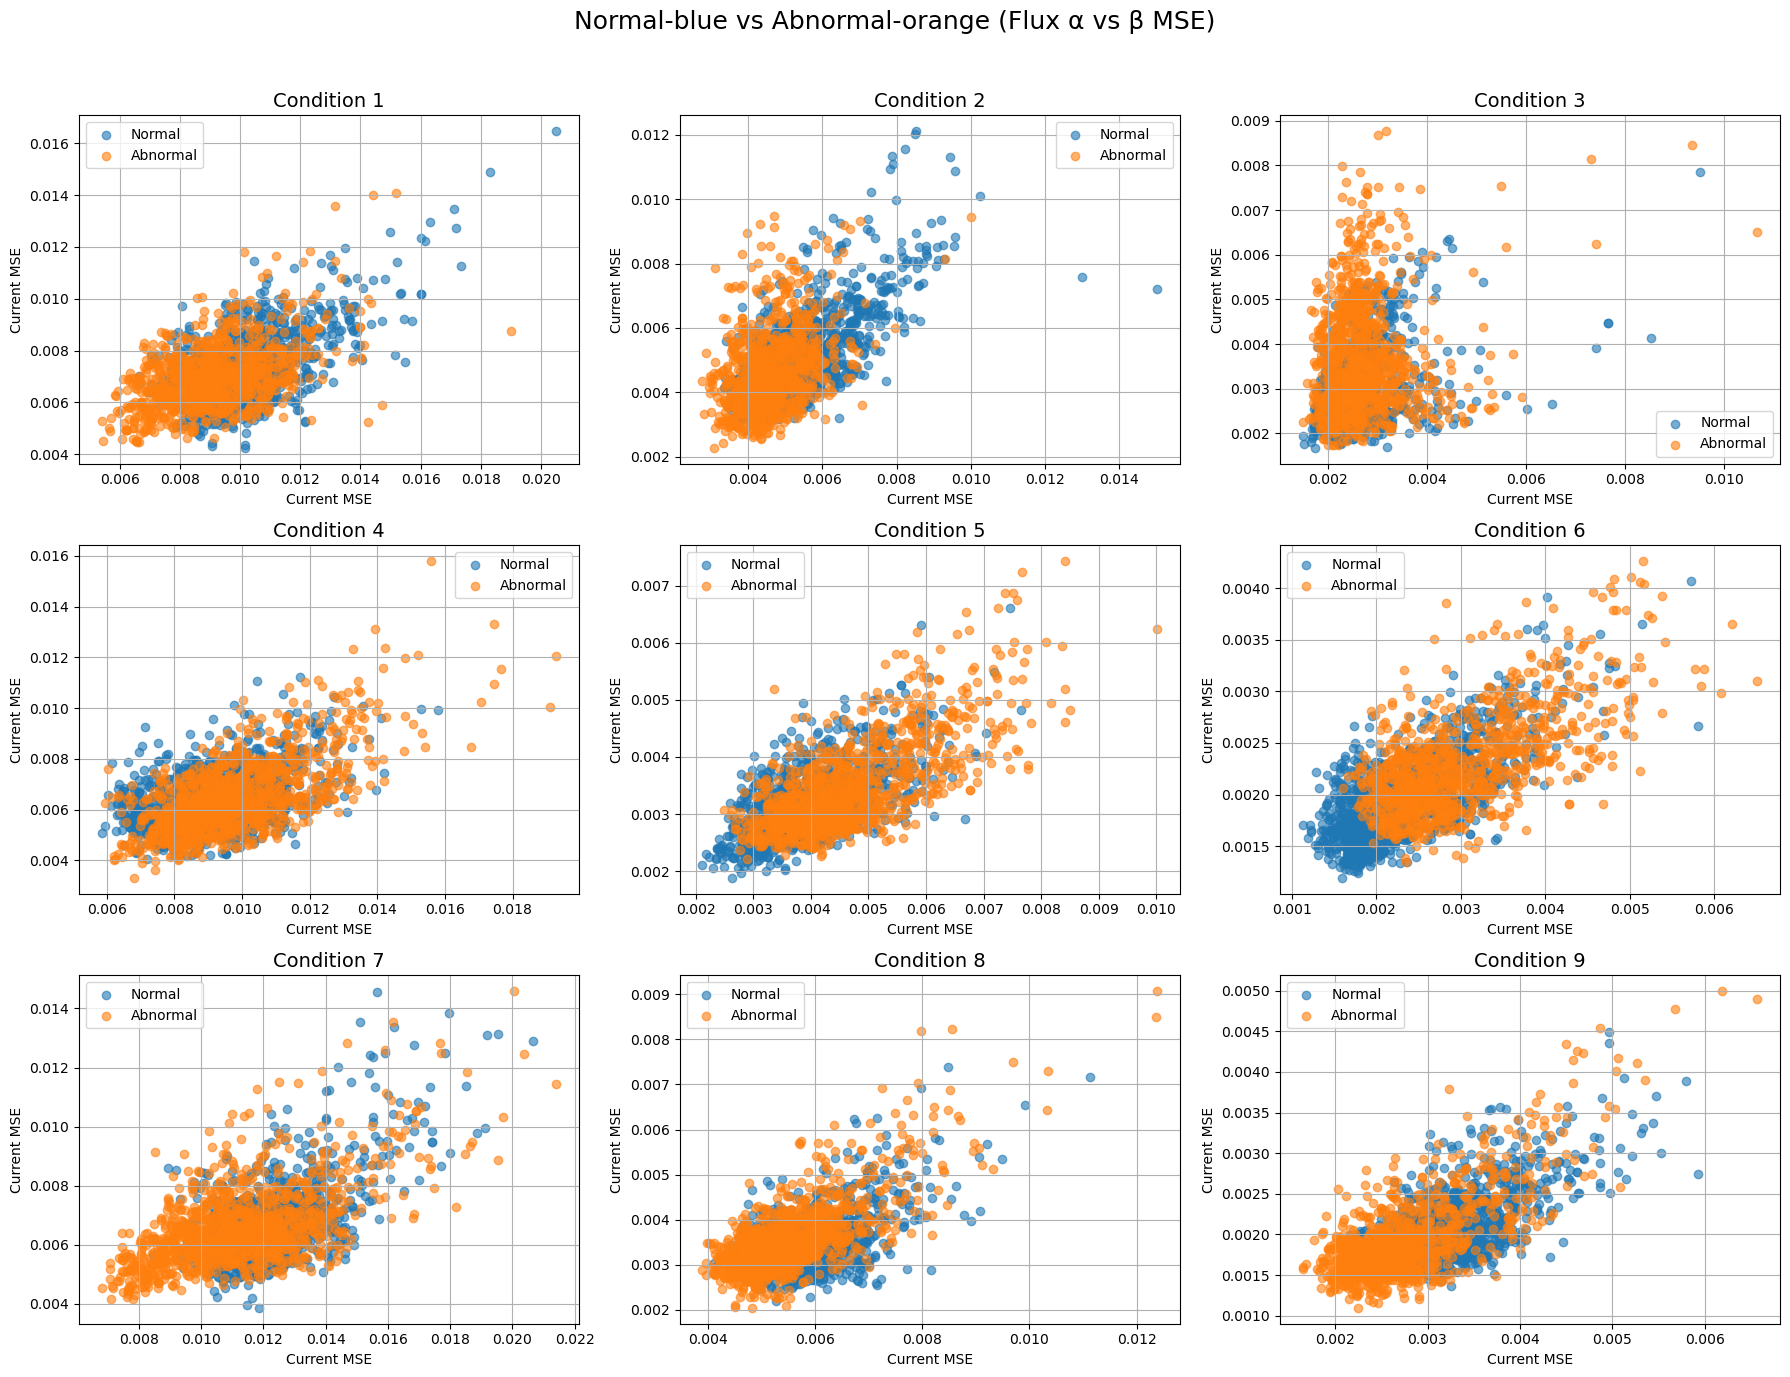

In [40]:

# 畫出兩者間的分布圖
# Step 0: 定義 Condition Map
my_model_I_in_I_out= load_model(os.path.join(model_path, model_name + '_I.keras'))
Condition_map = {
    '1200 0.5v': 'Condition 1',
    '1200 1.0v': 'Condition 2',
    '1200 2.0v': 'Condition 3',
    '1800 0.5v': 'Condition 4',
    '1800 1.0v': 'Condition 5',
    '1800 2.0v': 'Condition 6',
    '3000 0.5v': 'Condition 7',
    '3000 1.0v': 'Condition 8',
    '3000 2.0v': 'Condition 9',
}

#計算重建MSE資料
normal_reconstruction_errors_current = {}
for folder in Normal_subfolders:
    reconstruction_errors_current=my_model_I_in_I_out.predict(
        [normal_datasets[folder]["input_signals_normalized"][:, :, 2:4]],batch_size=128)
    mse_per_sample = np.mean((reconstruction_errors_current - normal_datasets[folder]["fit_signals_normalized"][:,:,2:4]) ** 2, axis=1)
    # print(mse_per_sample)
    normal_reconstruction_errors_current[folder] = {"Current_MSE_alpha": mse_per_sample[:,0],
                                                   "Current_MSE_beta": mse_per_sample[:,1]}
    
abnormal_reconstruction_errors_current = {}
for folder in Abnormal_subfolders:
    reconstruction_errors_current=my_model_I_in_I_out.predict(
        [abnormal_datasets[folder]["input_signals_normalized"][:, :, 2:4]], batch_size=128)
    mse_per_sample = np.mean((reconstruction_errors_current - abnormal_datasets[folder]["fit_signals_normalized"][:,:,2:4]) ** 2, axis=1)
    abnormal_reconstruction_errors_current[folder]= {"Current_MSE_alpha": mse_per_sample[:,0],
                                                   "Current_MSE_beta": mse_per_sample[:,1]}


# Step 2: 遍歷 Condition_map，找到每個 Condition 在兩個 dict 中的 key
matched_conditions = []
for cond_key in Condition_map:
    normal_key = next((k for k in normal_reconstruction_errors_current if cond_key in k), None)
    abnormal_key = next((k for k in abnormal_reconstruction_errors_current if cond_key in k), None)
    if normal_key and abnormal_key:
        matched_conditions.append((cond_key, normal_key, abnormal_key))

# Step 3: 畫圖
num_folders = len(matched_conditions)
num_figs = int(np.ceil(num_folders / 9))

for fig_idx in range(num_figs):
    fig, axes = plt.subplots(3, 3, figsize=(18, 14))
    fig.suptitle("Normal-blue vs Abnormal-orange (Flux α vs β MSE)", fontsize=18)

    for i in range(9):
        cond_idx = fig_idx * 9 + i
        if cond_idx >= num_folders:
            axes.flat[i].set_visible(False)
            continue

        cond_key, normal_key, abnormal_key = matched_conditions[cond_idx]
        ax = axes.flat[i]

        # Normal Data
        x_normal = normal_reconstruction_errors_current[normal_key]["Current_MSE_alpha"].flatten()
        y_normal = normal_reconstruction_errors_current[normal_key]["Current_MSE_beta"].flatten()
        # Abnormal Data
        x_abnormal = abnormal_reconstruction_errors_current[abnormal_key]["Current_MSE_alpha"].flatten()
        y_abnormal = abnormal_reconstruction_errors_current[abnormal_key]["Current_MSE_beta"].flatten()
        # 畫直方圖
        ax.scatter(x_normal, y_normal, label="Normal", color='tab:blue', alpha=0.6)
        ax.scatter(x_abnormal, y_abnormal, label="Abnormal", color='tab:orange', alpha=0.6)
    
        ax.legend()
        ax.set_xlabel("Current MSE")
        ax.set_ylabel("Current MSE")
        ax.set_title(Condition_map[cond_key], fontsize=14)
        ax.grid(True)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


### Second Part 同架構改純電流 ###

In [ ]:
# from datetime import datetime
# import json
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import Input, LSTM, Dense, Average, Add, Multiply, Lambda, GlobalAveragePooling1D
# from tensorflow.keras import backend as K


# model_folder_path = r'NTU_rul_models\time_series_models'
# model_current_name = f'CCAE_direct_lstm_multiscale_Current_Base{sequence_length}Future{future_length}'
# model_current_path = os.path.join(model_folder_path, model_name)
# os.makedirs(model_path, exist_ok=True)

# # === 所有 Lambda 替代函數 ===

# def get_past_input_theta(x, past_length):
#     return x[:, :past_length, :]

# def get_future_input_theta(x, future_length):
#     return x[:, future_length:, :]

# def slice_quarter_fn(x):
#     return x[:, -x.shape[1] // 4:, :]

# def slice_half_fn(x):
#     return x[:, -x.shape[1] // 2:, :]

# def fusion_fn(x):
#     return (x[0] + x[1] + x[2]) / 3.0


# def build_multiscale_lstm_fusion_model_current(past_length=128, future_length=128, latent_dim=32):
    
#     # === 輸入 ===
#     past_input_current = Input(shape=(past_length, 2), name='past_input_emf')
#     input_all_theta = Input(shape=(past_length + future_length, 1), name='past_input_all_theta')

#     # 替代 lambda 使用 Lambda + 自定義函式（注意使用 arguments 傳參數）
#     past_input_theta = Lambda(get_past_input_theta, arguments={'past_length': past_length}, name='past_input')(input_all_theta)
#     future_input_theta = Lambda(get_future_input_theta, arguments={'future_length': future_length}, name='future_input')(input_all_theta)

#     # 合併過去序列
#     # 合併過去序列
#     past_input_all = Concatenate(axis=-1, name='past_input_all')([past_input_current, past_input_theta])
    
#     # 多尺度切片（具名函式取代 Lambda）
#     x_quarter = Lambda(slice_quarter_fn, name="slice_quarter")(past_input_all)
#     x_half = Lambda(slice_half_fn, name="slice_half")(past_input_all)
#     x_all = past_input_all

#     # === Decoder 分支（含 Conv1D 殘差） ===
#     def decoder_branch(x_in, name):
#         _, h, c = LSTM(latent_dim, return_state=True, name=f"{name}_enc")(x_in)
#         x = LSTM(latent_dim, return_sequences=True, name=f"{name}_dec")(future_input_theta, initial_state=[h, c])
#         # Conv1D 濾出局部變化（不做殘差）
#         # x = Conv1D(32, kernel_size=3, padding='same', activation='relu', name=f"{name}_conv")(x)
#         return Dense(2, name=f"{name}_out")(x)

#     out_64 = decoder_branch(x_quarter, "net64")
#     out_96 = decoder_branch(x_half, "net96")
#     out_128 = decoder_branch(x_all, "net128")
    
#     # === 融合：學習式 softmax 加權平均 ===
#     def fusion_block(out_list, name="fusion"):
#         # 拼接所有輸出 (B, T, 6)
#         concat = Concatenate(name=f"{name}_concat")(out_list)
#         # 計算每個分支的 softmax 權重 (B, T, 3)
#         fusion_weights = Dense(3, activation='softmax', name=f"{name}_weights")(concat)
#         fusion_weights = Lambda(lambda x: tf.expand_dims(x, axis=-1), name=f"{name}_expand")(fusion_weights)  # (B, T, 3, 1)

#         # 堆疊預測值 (B, T, 3, 2)
#         pred_stack = Lambda(lambda x: tf.stack(x, axis=-2), name=f"{name}_stack")(out_list)

#         # 權重相乘 + 求和
#         weighted = Multiply(name=f"{name}_multiply")([fusion_weights, pred_stack])  # (B, T, 3, 2)
#         fused = Lambda(lambda x: tf.reduce_sum(x, axis=-2), name=f"{name}_output")(weighted)  # (B, T, 2)
#         return fused
    
#     # === 融合：簡單平均（取代學習式 softmax） ===
#     output_emf = Lambda(fusion_fn, name="fusion_output")([out_64, out_96, out_128])

#     model = Model(
#         inputs=[past_input_current, past_input_theta, future_input_theta],
#         outputs=[output_emf],
#         name="MSSW_LSTM_MultiTask3"
#     )

#     return model

# # build model 
# my_model_current = build_multiscale_lstm_fusion_model_current(past_length=sequence_length, future_length=future_length, latent_dim=128)
# my_model_current.compile(optimizer='adam', loss='mse')
# metadata = {
#     "model_name": model_name,
#     "sequence_length": sequence_length,
#     "layer_number": layer_number,
#     "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
#     "trained": False,
#     "train_date": None,
# }
# with open(os.path.join(model_current_path, model_current_name + '_metadata.json'), "w", encoding="utf-8") as f:
#     json.dump(metadata, f, ensure_ascii=False, indent=4)

# plot_model(my_model_current, to_file=os.path.join(model_current_path, model_current_name+'.png'), show_shapes=True, show_layer_names=True)

# my_model_current.predict([train_input_signals[0:1,:,-2:], past_theta[0:1,:,:], future_theta[0:1,:,:]])
# print("Model structure passed, start training...")

# gpus = tf.config.experimental.list_physical_devices('GPU')
# print("GPU devices found:")
# for gpu in gpus:
#     print(gpu)
# if gpus:
#     try:
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(e)

# lr_scheduler = ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.5,
#     patience=5,
#     min_lr=1e-6,
#     verbose=1
# )

# # 加入 EarlyStopping（恢復最佳權重）
# early_stop = EarlyStopping(
#     monitor='val_loss',
#     patience=5,           # 若 val_loss 連續5次沒有改善，就停止訓練
#     restore_best_weights=True,
#     verbose=1
# )

# history = my_model_current.fit(
#     x=[train_input_signals[:,:,-2:], past_theta, future_theta], 
#     y=train_fit_signals[:,:,:2],
#     batch_size=128,
#     epochs=20,
#     validation_split=0.1, 
#     callbacks=[lr_scheduler, early_stop] 
# )

# plt.figure(figsize=(8, 5))
# plt.plot(history.history['loss'], label='Training Loss')
# if 'val_loss' in history.history:
#     plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Training History')
# plt.legend()
# plt.grid(True)
# plt.show()

# metadata = {
#     "model_name": model_current_name,
#     "sequence_length": sequence_length,
#     "layer_number": layer_number,
#     "trained": True,
#     "train_date":  datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
# }
# with open(os.path.join(model_path, model_current_name + '_metadata.json'), "w", encoding="utf-8") as f:
#     json.dump(metadata, f, ensure_ascii=False, indent=4)

# print(f"Train input signals shape: {train_input_signals.shape}")
# # print(x_128.shape)
# # === 載入測試資料 ===

# # selected_folder=["1800_0_5V","1800_2_0V", "1200_1_0V",  "1200_0_5V"]  # 選擇特定資料夾
# testfile=r"D:\OneDrive\CCAE_experiments\CCAE_datasets\Normal2\0611_1800_2_0V\RUL_Data_3_2.parquet"
# # testfile=r"D:\OneDrive\CCAE_experiments\CCAE_datasets\drill 2X2\0531_1800_1_0V\RUL_Data_3_4.parquet"
# test_data = read_rul_data(testfile)
# start_idx=112

# # V/I歷史輸入與未來電壓
# past_vi = np.stack([
#     test_data["Voltage alpha downsample"][:sequence_length],
#     test_data["Voltage beta downsample"][:sequence_length],
#     test_data["Current alpha downsample"][:sequence_length],
#     test_data["Current beta downsample"][:sequence_length]
# ], axis=1)  # shape (128, 4)
# past_vi=np.expand_dims(past_vi, axis=0).astype(np.float32)


# speed_current_past = np.stack([
#     test_data["Current alpha downsample"][:sequence_length]* test_data["Speed"][0]/3000,   
#     test_data["Current beta downsample"][:sequence_length]* test_data["Speed"][0]/3000
# ], axis=1)  # shape (128, 2)
# speed_current_past = np.expand_dims(speed_current_past, axis=0).astype(np.float32)  # (1, 128, 2)

# x_future = np.stack([
#     test_data["Voltage alpha downsample"][sequence_length:sequence_length+future_length],
#     test_data["Voltage beta downsample"][sequence_length:sequence_length+future_length]
# ], axis=1)
# x_future=np.expand_dims(x_future, axis=0).astype(np.float32)  # (1, 128, 2)

# true_future_current = np.stack([
#     test_data["Current alpha downsample"][sequence_length:sequence_length+future_length],
#     test_data["Current beta downsample"][sequence_length:sequence_length+future_length]
# ], axis=1)


# past_emf=(past_voltage-past_current*Rs)/(speed*3000/60*2*np.pi)  # 計算電動勢
# time_stamp_all = np.arange(0, sequence_length + future_length,1)/Fs  # shape: (time_length,)
# theta_all_rad = speed * 3000 / 60 * 2 *np.pi* time_stamp_all 
# past_theta = theta_all_rad[:sequence_length, None]  # 取前 sequence_length 個時間步長
# future_theta = theta_all_rad[sequence_length:sequence_length+future_length, None]

# # 確認資料形狀
# # 印出輸入變數名稱與形狀
# print(f"past_vi shape: {past_vi.shape}")
# print(f"speed_current_past shape: {speed_current_past.shape}")
# print(f"x_future shape: {x_future.shape}")
# print(f"speed shape: {speed.shape}")
# print(f"torque shape: {torque.shape}")
# print(f"past_current shape: {past_current.shape}")  
# print(f"current_diff_past shape: {current_diff_past.shape}  ")
  
  
# # === 預測 ===
# y_future_pred = my_model_current.predict([
#     past_vi[:,:,-2:], 
#     past_theta[None, :], 
#     future_theta[None, :]
# ])
# print(len(y_future_pred))
# y_future_pred=y_future_pred[0]  # 去掉 batch 維度


# # === 繪圖：歷史 + 未來預測 ===
# plt.figure(figsize=(10, 5))
# plt.plot(range(sequence_length), past_current[:, 0], color='black', label='True emf Alpha (history)')
# plt.plot(range(sequence_length), past_current[:, 1], color='gray', label='True emf Beta (history)')
# plt.plot(range(sequence_length, sequence_length+future_length), true_future_current[ :, 0], color='tab:blue', label='True emf Alpha (future)')
# plt.plot(range(sequence_length, sequence_length+future_length), true_future_current[ :, 1], color='tab:orange', label='True emf Beta (future)')
# plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 0], color='tab:green', linestyle='--', label='Predicted emf Alpha')
# plt.plot(range(sequence_length, sequence_length+future_length), y_future_pred[:, 1], color='tab:red', linestyle='--', label='Predicted emf Beta')
# plt.title('Current Prediction (with Known History)')
# plt.xlabel('Time Step')
# plt.ylabel('Current Value')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

# # === 繪圖：預測誤差 ===

# plt.figure(figsize=(10, 5))
# residuals = y_future_pred - true_future_current[0]
# residual_rms= np.sqrt(np.mean(residuals**2, axis=0))
# plt.plot(range(sequence_length, sequence_length+future_length), residuals[:, 0], color='tab:green', label=f'Residual Alpha, RMS={residual_rms[0]:.4f}')
# plt.plot(range(sequence_length, sequence_length+future_length), residuals[:, 1], color='tab:red', label=f'Residual Beta, RMS={residual_rms[0]:.4f}')
# plt.title('Current Prediction Residuals (Predicted - True)')
# plt.xlabel('Time Step')
# plt.ylabel('Residual Value')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()


### 導入 RUL 資料 ###

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 假設你已經定義好了這些（要根據你自己的實作引入）
# from your_module import read_rul_data, 
# , my_model, Rs, Fs, sequence_length, future_length

def process_rul_folder_avg_mse_batch(RUL_test_folder, sequence_length, future_length, augmen_sample_number, Rs, Fs):
    rul_files = [os.path.join(RUL_test_folder, f) for f in os.listdir(RUL_test_folder) if f.endswith(".parquet")]
    rul_files.sort(key=lambda f: int(os.path.splitext(os.path.basename(f))[0].split('_')[-1]))

    # 用來累積所有檔案的 augmentation 結果
    all_input_seq = []
    all_future_seq = []
    all_torque = []
    all_speed = []
    file_index_ranges = []

    total_index = 0

    for file_path in rul_files:
        df = read_rul_data(file_path)

        signals = np.stack([
            np.array(df["Voltage alpha downsample"]),
            np.array(df["Voltage beta downsample"]),
            np.array(df["Current alpha downsample"]),
            np.array(df["Current beta downsample"])
        ], axis=1)

        augmented = data_random_augmentation(
            signals,
            sequence_length=sequence_length,
            augmen_sample_number=augmen_sample_number,
            future_length=future_length
        )

        input_seq = augmented[:, :sequence_length, :]
        future_seq = augmented[:, sequence_length:, :]

        torque = df["Torque avg"]
        speed = df["Speed"][0] / 3000

        torque_array = np.ones((augmen_sample_number, 1)) * torque
        speed_array_pu = np.ones((augmen_sample_number, 1)) * speed

        all_input_seq.append(input_seq)
        all_future_seq.append(future_seq)
        all_torque.append(torque_array)
        all_speed.append(speed_array_pu)

        file_index_ranges.append((total_index, total_index + augmen_sample_number))
        total_index += augmen_sample_number

    # 合併所有資料
    input_seq_all = np.concatenate(all_input_seq, axis=0)
    future_seq_all = np.concatenate(all_future_seq, axis=0)
    torque_all = np.concatenate(all_torque, axis=0)
    speed_all = np.concatenate(all_speed, axis=0) # per unit speed

    # theta 計算
    time_sequence_all = np.arange(0, sequence_length + future_length)[None, :, None] / Fs
    theta_all_rad = speed_all[:, None, :] * time_sequence_all * 3000 / 60 * 2 * np.pi
    past_theta = theta_all_rad[:, :sequence_length, :]
    future_theta = theta_all_rad[:, sequence_length:, :]

    # emf 計算
    emf_past = (input_seq_all[:, :, 0:2] - input_seq_all[:, :, 2:4] * Rs) / (speed_all[:, None, :] * 3000 / 60 * 2 * np.pi)
    emf_future_true = (future_seq_all[:, :, 0:2] - future_seq_all[:, :, 2:4] * Rs) / (speed_all[:, None, :] * 3000 / 60 * 2 * np.pi)

    # 批量預測
    emf_future_pred = my_model.predict([emf_past, speed_all, torque_all], verbose=1)

    # 計算每段 MSE
    mse_per_sample = np.mean((emf_future_pred - emf_future_true) ** 2, axis=(1, 2))

    # 回分每個檔案的平均 MSE
    errors = []
    for start_idx, end_idx in file_index_ranges:
        file_mse = np.mean(mse_per_sample[start_idx:end_idx])
        errors.append(file_mse)

    return np.array(errors)



augmen_sample_number = 100

RUL_test_folder1 = r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0703_3000_10P_1.0V_1"
errors1 = process_rul_folder_avg_mse_batch(RUL_test_folder1, sequence_length, future_length, augmen_sample_number, Rs, Fs)

RUL_test_folder2 = r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0710_3000_10_1.0v_3"
errors2 = process_rul_folder_avg_mse_batch(RUL_test_folder2, sequence_length, future_length, augmen_sample_number, Rs, Fs)

RUL_test_folder3 = r"D:\OneDrive\RUL HI Reasearch Result\Data_sets\NTU_RUL_v2_data\Acc_life_test_data\Uncategorized_Data\0718_1200_15p_1.0v_1"
errors3 = process_rul_folder_avg_mse_batch(RUL_test_folder3, sequence_length, future_length, augmen_sample_number, Rs, Fs)


1110/1110 [==============================] - 39s 35ms/step


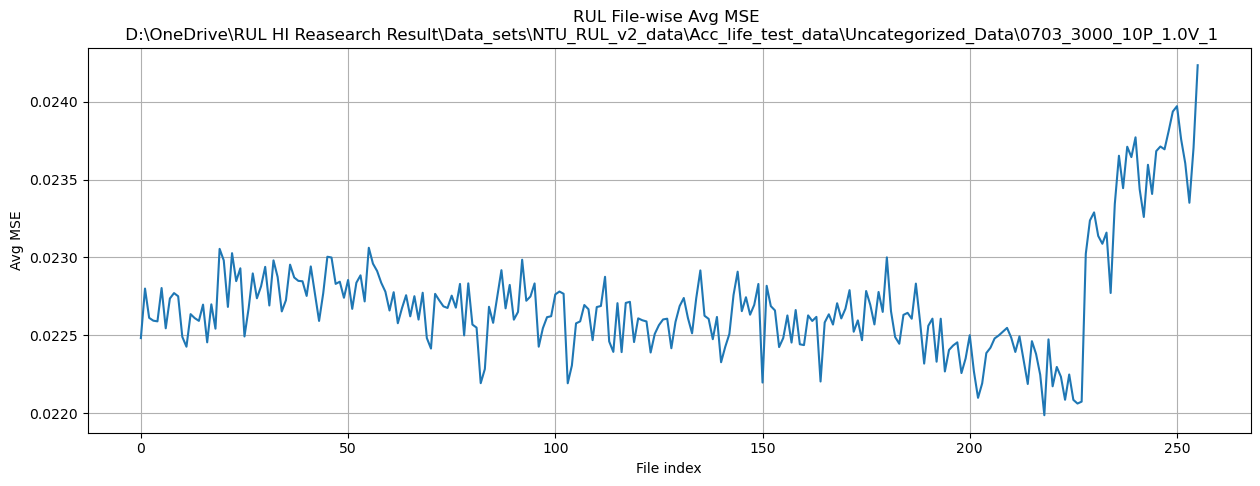

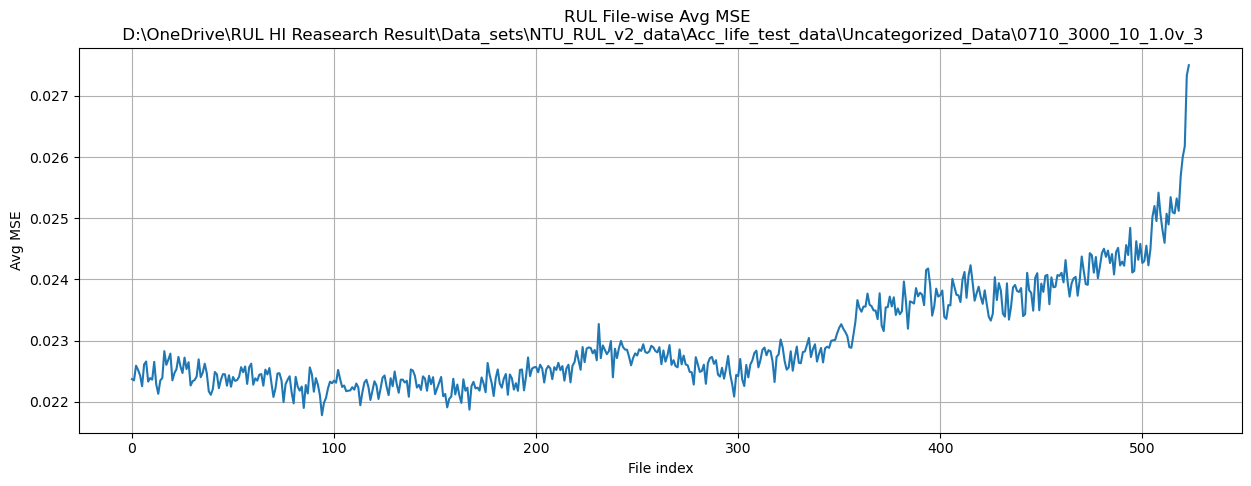

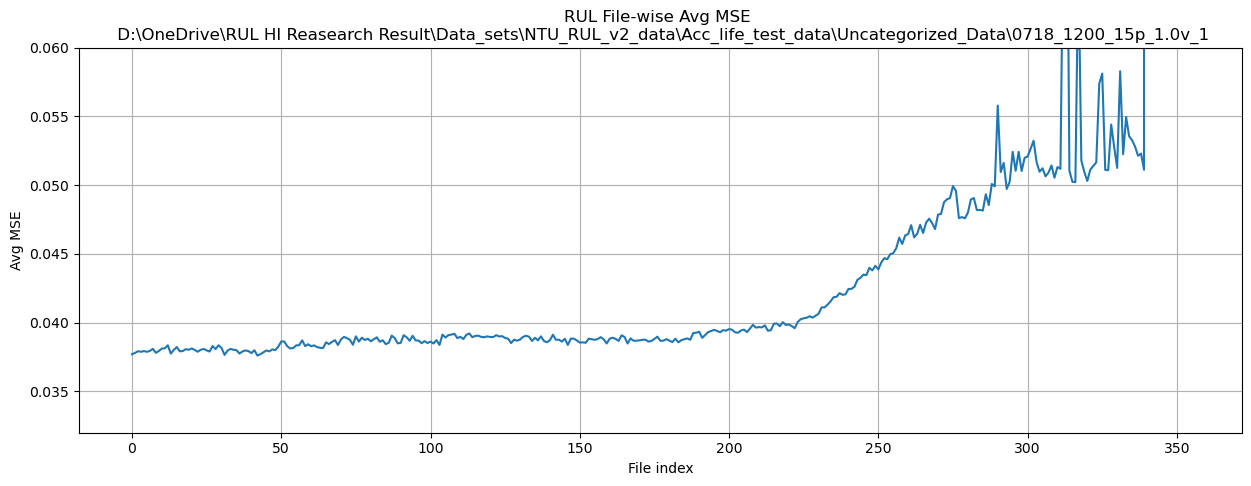

In [ ]:

# 顯示結果
plt.figure(figsize=(15, 5))
plt.plot(errors1)
plt.title(f"RUL File-wise Avg MSE \n {RUL_test_folder1}")
plt.xlabel("File index")
plt.ylabel("Avg MSE")
# plt.ylim(0.04, 0.1)
plt.grid()
plt.show()

# 顯示結果
plt.figure(figsize=(15, 5))
plt.plot(errors2)
plt.title(f"RUL File-wise Avg MSE \n {RUL_test_folder2}")
plt.xlabel("File index")
plt.ylabel("Avg MSE")
# plt.ylim(0.04, 0.1)
plt.grid()
plt.show()

# 顯示結果
plt.figure(figsize=(15, 5))
plt.plot(errors3)
plt.title(f"RUL File-wise Avg MSE \n {RUL_test_folder3}")
plt.xlabel("File index")
plt.ylabel("Avg MSE")
plt.ylim(0.032, 0.06)
plt.grid()
plt.show()

